## Wind field cases

TODO:

- Compute relative errors (between Kepert models and SAR) for individual cases?
- Add rain flags for HY-2
 
1) Intro plots (note the motion/shear vectors describe how much the storm/shear moved forward during 1 hour)

2) KXX_PRM wind field inferences

3) Same for FIT (Appendix)

4) Same for wIA (Appendix)

5) HY2 wind field estimates

6) Wind profile and inflow angle profile estimates in both models and observations

----
List of interesting cases

Larry (al122021) on 09-07 at 2148 UTC ==> Regular w.r.t motion/shear, nice SAR, nice SCT, nice BL FIT, I > V/r; but maybe a little bit weak. 

Nigel (al152023) on 09-19 at 0931 UTC ==> Regular w.r.t motion/shear, nice SAR, nice SCT, nice BL FIT, I > V/r; but maybe a little bit weak. 

Lee (al132023) on 09-09 at 0950 UTC ==> Regular w.r.t motion/shear, nice SAR, nice SCT, nice BL FIT, I > V/r; moderate (stronger than Larry and Nigel, and small Rmax, so good case). 

Lee (al132023) on 09-10 at 2213 UTC ==> Regular w.r.t motion/shear, nice SAR, nice SCT, nice BL FIT, I > V/r; moderate (stronger than Larry and Nigel, and small Rmax, so good case). 

Gilma (ep072024) on 08-23 at 1416 UTC ==> Irregular w.r.t motion/shear, nice SAR, nice SCT, nice BL FIT, I > V/r; weak. 

Milton (al142024) on 10-07 at 0022 UTC ==> Irregular w.r.t motion/shear, nice SAR, nice SCT, nice BL FIT, I > V/r; weak. 

Koinu (wp142023) on 10-03 at 0945 UTC ==> Irregular w.r.t motion/shear, nice SAR, nice SCT, nice BL FIT, I > V/r; weak but still Vmax ~ 45 m/s, big eye though.

Chanthu (wp192021) on 09-08 at 2115 UTC ==> Not on the asymmetry plot (too smooth?), nice SAR, nice SCT, nice BL FIT, I < V/r but ok; intense!

Freddy (sh112023) on 02-16 at 0012 UTC ==> Not on the asymmetry plot (because it is Southern hemisphere!) but would be an interesting case, nice SAR, nice SCT, nice BL FIT, I < V/r but ok; intense! Also nice case on 02-18 at 1400 UTC.

Bolaven (wp152023) on 10-11 at 0840 UTC ==> Regular w.r.t motion/shear, nice SAR, nice SCT, moderatly nice BL FIT, I > V/r; intense!

Mawar (wp022023) on 05-26 at 0855 UTC ==> Regular w.r.t motion/shear, nice SAR, nice SCT, nice BL FIT, I > V/r; intense!

Dora (ep052023) on 08-09 at 0501 UTC ==> Regular w.r.t motion/shear, nice SAR, nice SCT, nice BL FIT, I < V/r but ok; intense! Very nice case despite the I < V/r!!!

Kirk also has nice cases in the range Vmax~50 m/s. rcm1-sclnb-owi-ca-20241004t090911-20241004t091027-00003-xxxxx_sw_al122024_cyclone_polar.nc

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth':     '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir':     '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir':     '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/04_WIND_FIELD_CASES/',
    'sct_dir':     '/home/arthur/data/tropical_cyclones/scatterometer/hy-2/',
    'dsa_pth':     '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/02_ASYMM_SHEAR_MOTION/dsa.nc',
    'K01_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K01/cases/',
    'K01_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/cases/',
    'K01_wIA_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/unweighted_rmse/reduced_area_150k/masked_rain/cases/',
    'K01_wZU_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wZU/unweighted_rmse/reduced_area_150k/cases/',
    'K25_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/cases/',
    'K25_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/cases/',
    'K25_wIA_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/unweighted_rmse/reduced_area_150k/masked_rain/cases/',
    'K25_wZU_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wZU/unweighted_rmse/reduced_area_150k/cases/',
    'ZU12_dir':    '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_ZU12/cases/',
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [3]:
# ### OLD

# # FILTERS
# cond = (
#     (dsg.center_quality_flag < 2) & 
#     (dsg.percent_outside < 50) & 
#     (dsg.percent_rmx_inside == 1) &
#     (abs(dsg.lat) < 30) & 
#     (dsg.rmx < 100000) & 
#     (dsg.vmx > 20)
# )
# dsg_filtered    = dsg.where(cond, drop=True)
# print(len(dsg_filtered.time))

In [4]:
# FILTERS
cond = (
    # (dsg.lat > 0) &             # Northern hemisphere; Remove this filter?
    (dsg.dist2coast  > dsg.r34) & # Distance to coast
    (dsg.percent_outside < 10)  & # Sufficient SAR coverage
    (dsg.vmx > 20)    
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

606


In [5]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette      = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [6]:
### Create ref. grid, choose resolution
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

def get_cartesian_wind_from(dss):
    '''Displayed in geographical referential (i.e top is North)'''
    dr, th       = np.meshgrid(dss.rad, dss.theta)
    th           = th + float(dss.rotation_angle) + 90
    th           = np.deg2rad(th % 360)
    ds_x, ds_y   = pol2cart(dr, th)
    ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dss.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='nearest')
    return ws_car

def get_storm_oriented_cartesian_wind_from(dss):
    '''Displayed in storm-oriented referential (i.e top is motion direction)'''
    dr, th       = np.meshgrid(dss.rad, dss.theta)
    th           = th + 90 # Convert to polar th, i.e 0° = positive x-axis, 90° = positive y-axis
    th           = np.deg2rad(th % 360)
    ds_x, ds_y   = pol2cart(dr, th)
    ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dss.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='nearest')
    return ws_car

In [7]:
### COLORMAP SAR
import sys
import os

# Ajoutez le dossier parent 'my_modules' au chemin de recherche
# Le chemin '..' permet de remonter d'un niveau par rapport à l'emplacement du notebook
module_path = os.path.abspath(os.path.join('../../..', 'tools/'))
print(f"Chemin du module à ajouter : {module_path}")

if module_path not in sys.path:
    sys.path.append(module_path)
    
# Importez la classe CMAP depuis votre script
from cmap_sar import CMAP

# Maintenant, vous pouvez appeler les méthodes de la classe CMAP
cmap_cyclobs, vmin, vmax = CMAP.cyclobs_wind10m(return_vminvmax=True, unit="m/s")
print(f"Colormap créée : {cmap_cyclobs.name}")
print(f"Valeurs min/max : {vmin:.2f} m/s et {vmax:.2f} m/s")
ticks_cyclobs = [5.14444, 17.4911, 25.7222, 32.9244, 42.6989, 49.1433, 58.1, 69.959]

Chemin du module à ajouter : /home/arthur/scripts/tools
Colormap créée : cyclobs_wind10m
Valeurs min/max : 0.00 m/s et 69.96 m/s


In [8]:
# ### Open asymmetry information
# dsasymmetry = xr.open_dataset(PTHS['dsa_pth'])

# # Compute phase of max. asymmetry
# l_phs_max = []
# for t in tqdm(range(len(dsasymmetry.time))):
#     l_phs_max.append(float(dsasymmetry.isel(time=t).phs[dsasymmetry.isel(time=t).rad >= 1].isel(rad=dsasymmetry.isel(time=t).acn[dsasymmetry.isel(time=t).rad >= 1].argmax())))
# dsasymmetry['phs_max'] = xr.DataArray(l_phs_max, coords={'time': dsasymmetry.time})

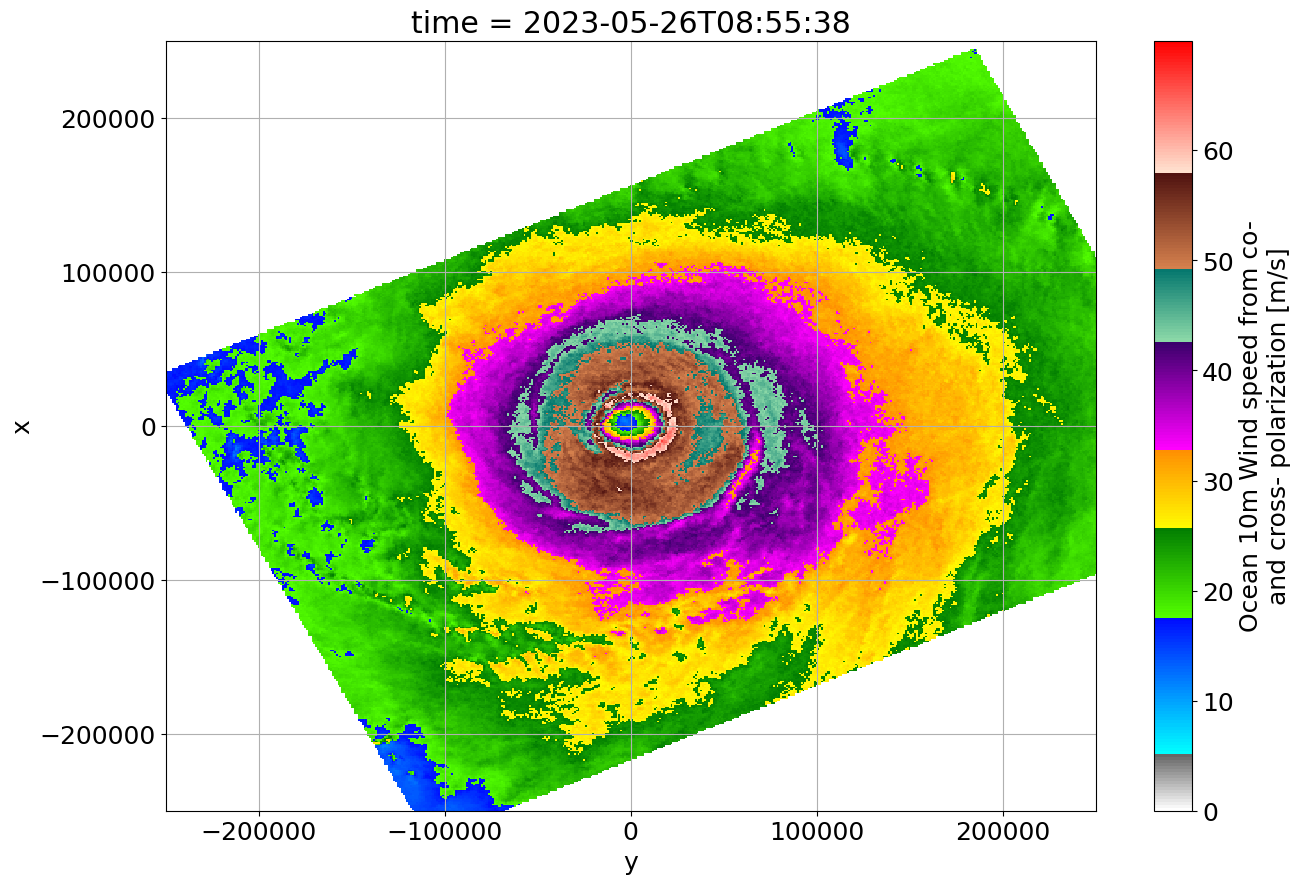

In [9]:
dsca = xr.open_dataset(PTHS['sav_dir'] + 'rcm2-sclna-owi-ca-20230526t085500-20230526t085617-00003-xxxxx_sw_wp022023_cyclone_gd.nc').isel(time=0)

dsca.wind_speed.plot(cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
plt.xlim(-250000, 250000)
plt.ylim(-250000, 250000)
plt.grid()

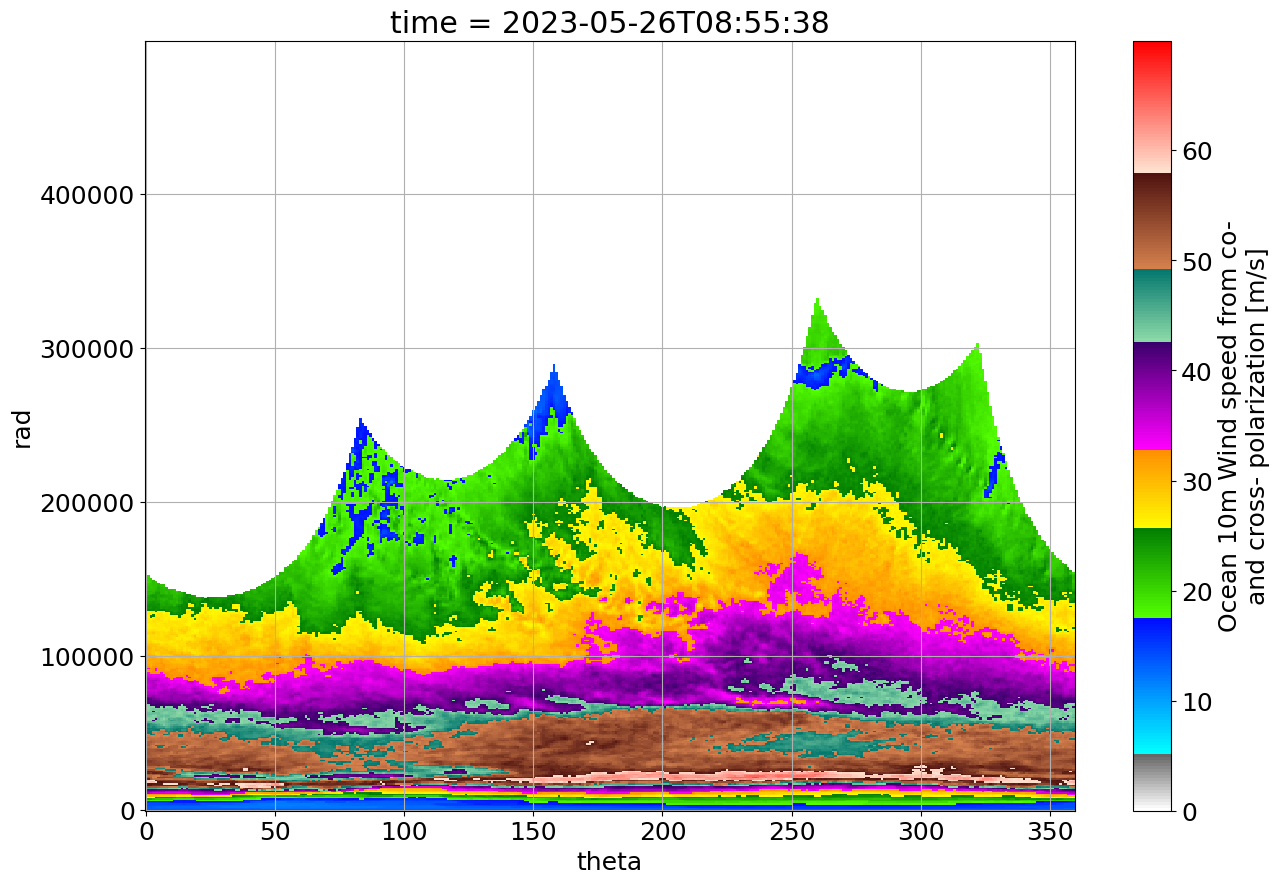

In [11]:
# Open files
caseA           = dsg_filtered.where(dsg_filtered.name == 'MAWAR', drop=True).isel(time=4)
fileA           = caseA.file_tcva.item()
dsa             = xr.open_dataset(PTHS['sar_dir'] + fileA).isel(time=0)

dsa.wind_speed.plot(cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
plt.grid()

### 1) Intro plots

In [25]:
# Open files
# caseA           = dsg_filtered.where(dsg_filtered.name == 'MAWAR', drop=True).isel(time=4)
# fileA           = caseA.file_tcva.item()
# dsa             = xr.open_dataset(PTHS['sar_dir'] + fileA).isel(time=0)

# caseA           = dsg_filtered.where(dsg_filtered.name == 'DORA', drop=True).isel(time=3)
# fileA           = caseA.file_tcva.item()
# dsa             = xr.open_dataset(PTHS['sar_dir'] + fileA).isel(time=0)

caseA           = dsg_filtered.where(dsg_filtered.name == 'BOLAVEN', drop=True).isel(time=0)
fileA           = caseA.file_tcva.item()
dsa             = xr.open_dataset(PTHS['sar_dir'] + fileA).isel(time=0)

caseB           = dsg_filtered.where(dsg_filtered.name == 'KOINU', drop=True).isel(time=1)
fileB           = caseB.file_tcva.item()
dsb             = xr.open_dataset(PTHS['sar_dir'] + fileB).isel(time=0)

# caseB           = dsg_filtered.where(dsg_filtered.name == 'MILTON', drop=True).isel(time=1)
# fileB           = caseB.file_tcva.item()
# dsb             = xr.open_dataset(PTHS['sar_dir'] + fileB).isel(time=0)

# caseB           = dsg_filtered.where(dsg_filtered.name == 'GILMA', drop=True).isel(time=1)
# fileB           = caseB.file_tcva.item()
# dsb             = xr.open_dataset(PTHS['sar_dir'] + fileB).isel(time=0)

# Azimuthal Location of Max. Wind rel. to Motion (x-axis of synthetic figure)
# pma             = dsasymmetry.where(dsasymmetry.file_tcva == fileA, drop=True).isel(time=0).phs_max
pma             = dsa.sel(rad=caseA.rmx).wind_speed.idxmax()
pma             = np.deg2rad(-pma % 360) # Clockwise from storm motion!
# pmb             = dsasymmetry.where(dsasymmetry.file_tcva == fileB, drop=True).isel(time=0).phs_max
pmb             = dsb.sel(rad=caseB.rmx).wind_speed.idxmax()
pmb             = np.deg2rad(-pmb % 360) # Clockwise from storm motion!
MaxLocRel2MotA  = xr.where(np.rad2deg(pma) < 180, np.rad2deg(pma), np.rad2deg(pma) - 360)
MaxLocRel2MotB  = xr.where(np.rad2deg(pmb) < 180, np.rad2deg(pmb), np.rad2deg(pmb) - 360)
xma, yma        = pol2cart(caseA.rmx, np.deg2rad(-MaxLocRel2MotA + 90))
xmb, ymb        = pol2cart(caseB.rmx, np.deg2rad(-MaxLocRel2MotB + 90))
# Shear Direction rel. to Motion (y-axis of synthetic figure)
relShrDir_caseA = (caseA.wsd_pmd - caseA.storm_dir_ibt) % 360
ShrDirRel2MotA  = xr.where(relShrDir_caseA < 180, relShrDir_caseA, relShrDir_caseA - 360)
relShrDir_caseB = (caseB.wsd_pmd - caseB.storm_dir_ibt) % 360
ShrDirRel2MotB  = xr.where(relShrDir_caseB < 180, relShrDir_caseB, relShrDir_caseB - 360)
xsa, ysa        = pol2cart(caseA.vws_pmd * 3600, np.deg2rad(-ShrDirRel2MotA + 90)) # Put a sign "minus" because my definition is for ShrDirRel2MotA uses an anti-trigonometric formulation
xsb, ysb        = pol2cart(caseB.vws_pmd * 3600, np.deg2rad(-ShrDirRel2MotB + 90)) # Added +90° to account for the fact that the storm is moving North

# # Do these two below lines of code at the end otherwise it screws the MaxLocRel2Mot estimates
# dsa['theta']    = dsa['theta'] - dsa.rotation_angle # So that the storm goes to top of the page
# dsb['theta']    = dsb['theta'] - dsb.rotation_angle # So that the storm goes to top of the page

# Where are the 2 cases located on the synthetic figure?
print(float(MaxLocRel2MotA), float(ShrDirRel2MotA))
print(float(MaxLocRel2MotB), float(ShrDirRel2MotB))

144.0 124.87475263171726
-160.0 -87.3224272201802


In [26]:
# Convert to cartesian
wsca = get_storm_oriented_cartesian_wind_from(dsa)
wscb = get_storm_oriented_cartesian_wind_from(dsb)

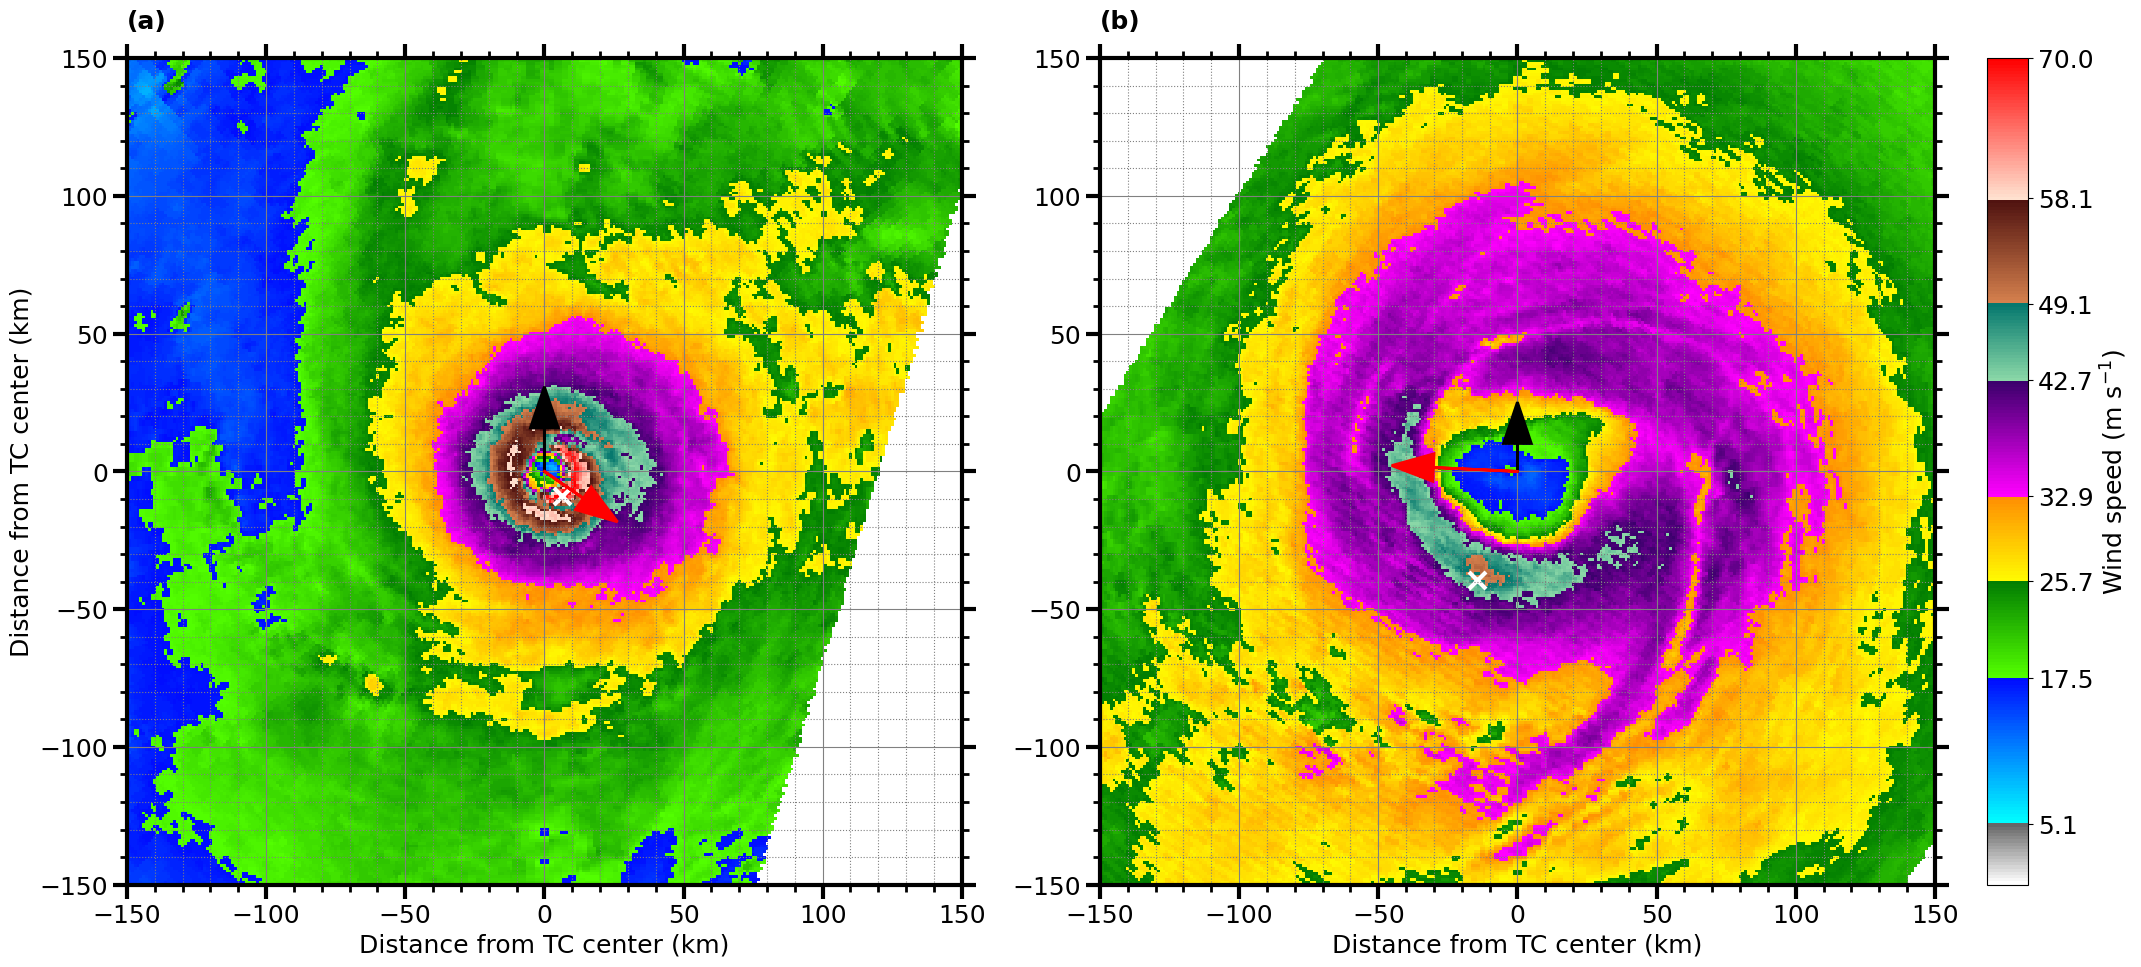

In [28]:
# Create figure with subplots
fig = plt.figure(figsize=(22, 10))
gs  = GridSpec(1, 2, width_ratios=[1, 1.25])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax_lims2D  = 150

#####################
### SAR  A  SPEED ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# SAR wind speeds
# im1     = ax1.pcolormesh(x_ref / 1000, y_ref / 1000, wsca, cmap=cwnd, norm=normalizer)
im1     = ax1.pcolormesh(x_ref / 1000, y_ref / 1000, wsca, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)

# Motion vector
ax1.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseA.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)    
# Shear direction
ax1.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsa) / 1000,                # dx: 50 km (points right)
    float(ysa) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax1.scatter(xma / 1000, yma / 1000, marker='x', s=150, c='white', linewidth=3)

ax1.set_xlim(-ax_lims2D, ax_lims2D);ax1.set_ylim(-ax_lims2D, ax_lims2D)
ax1.set_xlabel('Distance from TC center (km)')
ax1.set_ylabel('Distance from TC center (km)')

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

#####################
### SAR  B  SPEED ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# SAR wind speeds
# im2     = ax2.pcolormesh(x_ref / 1000, y_ref / 1000, wscb, cmap=cwnd, norm=normalizer)
im2     = ax2.pcolormesh(x_ref / 1000, y_ref / 1000, wscb, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)

# Motion vector
ax2.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseB.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)   
# Shear direction
ax2.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsb) / 1000,                # dx: 50 km (points right)
    float(ysb) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                           # Face color
    ec='r',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax2.scatter(xmb / 1000, ymb / 1000, marker='x', s=150, c='white', linewidth=3)

ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.set_xlabel('Distance from TC center (km)')

# cbar = plt.colorbar(im1, ax=ax2)
cbar = plt.colorbar(im1, ax=ax2, ticks=ticks_cyclobs)
cbar.set_ticklabels([round(tick, 1) for tick in ticks_cyclobs])
cbar.set_label(r'Wind speed (m s$^{-1}$)')

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Final adjustments
plt.tight_layout()

# # Save
# plt.savefig(PTHS['sav_dir'] + 'Intro_cases.png', bbox_inches='tight')

### 2) KXX_PRM winds

In [29]:
def get_cartesian_var_from_kepert(dsk, var):
    dr, th       = np.meshgrid(dsk.rad, dsk.theta)
    th           = np.deg2rad(th + 90 % 360)
    ds_x, ds_y   = pol2cart(dr, th)
    ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsk[var]).flatten(), (x_ref, y_ref), method='nearest')
    return ws_car

alpha = np.arctan2(y_ref, x_ref)
step  = 10

In [30]:
# Open datasets
k01pA      = xr.open_dataset(PTHS['K01_PRM_dir'] + '{}.nc'.format(fileA[:-17])).sel(z=10)
k01pB      = xr.open_dataset(PTHS['K01_PRM_dir'] + '{}.nc'.format(fileB[:-17])).sel(z=10)
k25pA      = xr.open_dataset(PTHS['K25_PRM_dir'] + '{}.nc'.format(fileA[:-17])).sel(z=10)
k25pB      = xr.open_dataset(PTHS['K25_PRM_dir'] + '{}.nc'.format(fileB[:-17])).sel(z=10)

In [31]:
# Convert to cartesian datasets and compute zonal (U) and meridional (V) wind components
Vtot_k01pA = get_cartesian_var_from_kepert(k01pA, 'wind_speed')
Vrad_k01pA = get_cartesian_var_from_kepert(k01pA, 'rad_wind')
Vtan_k01pA = get_cartesian_var_from_kepert(k01pA, 'tan_wind')
Uk01pA     = Vrad_k01pA * np.cos(alpha) - Vtan_k01pA * np.sin(alpha)
Vk01pA     = Vrad_k01pA * np.sin(alpha) + Vtan_k01pA * np.cos(alpha)
print('Case A K01 PRM converted.')

Vtot_k01pB = get_cartesian_var_from_kepert(k01pB, 'wind_speed')
Vrad_k01pB = get_cartesian_var_from_kepert(k01pB, 'rad_wind')
Vtan_k01pB = get_cartesian_var_from_kepert(k01pB, 'tan_wind')
Uk01pB     = Vrad_k01pB * np.cos(alpha) - Vtan_k01pB * np.sin(alpha)
Vk01pB     = Vrad_k01pB * np.sin(alpha) + Vtan_k01pB * np.cos(alpha)
print('Case B K01 PRM converted.')

Vtot_k25pA = get_cartesian_var_from_kepert(k25pA, 'wind_speed')
Vrad_k25pA = get_cartesian_var_from_kepert(k25pA, 'rad_wind')
Vtan_k25pA = get_cartesian_var_from_kepert(k25pA, 'tan_wind')
Uk25pA     = Vrad_k25pA * np.cos(alpha) - Vtan_k25pA * np.sin(alpha)
Vk25pA     = Vrad_k25pA * np.sin(alpha) + Vtan_k25pA * np.cos(alpha)
print('Case A K25 PRM converted.')

Vtot_k25pB = get_cartesian_var_from_kepert(k25pB, 'wind_speed')
Vrad_k25pB = get_cartesian_var_from_kepert(k25pB, 'rad_wind')
Vtan_k25pB = get_cartesian_var_from_kepert(k25pB, 'tan_wind')
Uk25pB     = Vrad_k25pB * np.cos(alpha) - Vtan_k25pB * np.sin(alpha)
Vk25pB     = Vrad_k25pB * np.sin(alpha) + Vtan_k25pB * np.cos(alpha)
print('Case B K25 PRM converted.')

Case A K01 PRM converted.
Case B K01 PRM converted.
Case A K25 PRM converted.
Case B K25 PRM converted.


/tmp/ipykernel_8621/2166398464.py:107: UserWarning: Adding colorbar to a different Figure <Figure size 2200x1000 with 3 Axes> than <Figure size 2200x2000 with 5 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im1, ax=ax2, ticks=ticks_cyclobs)
/tmp/ipykernel_8621/2166398464.py:218: UserWarning: Adding colorbar to a different Figure <Figure size 2200x1000 with 3 Axes> than <Figure size 2200x2000 with 6 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im1, ax=ax4, ticks=ticks_cyclobs)


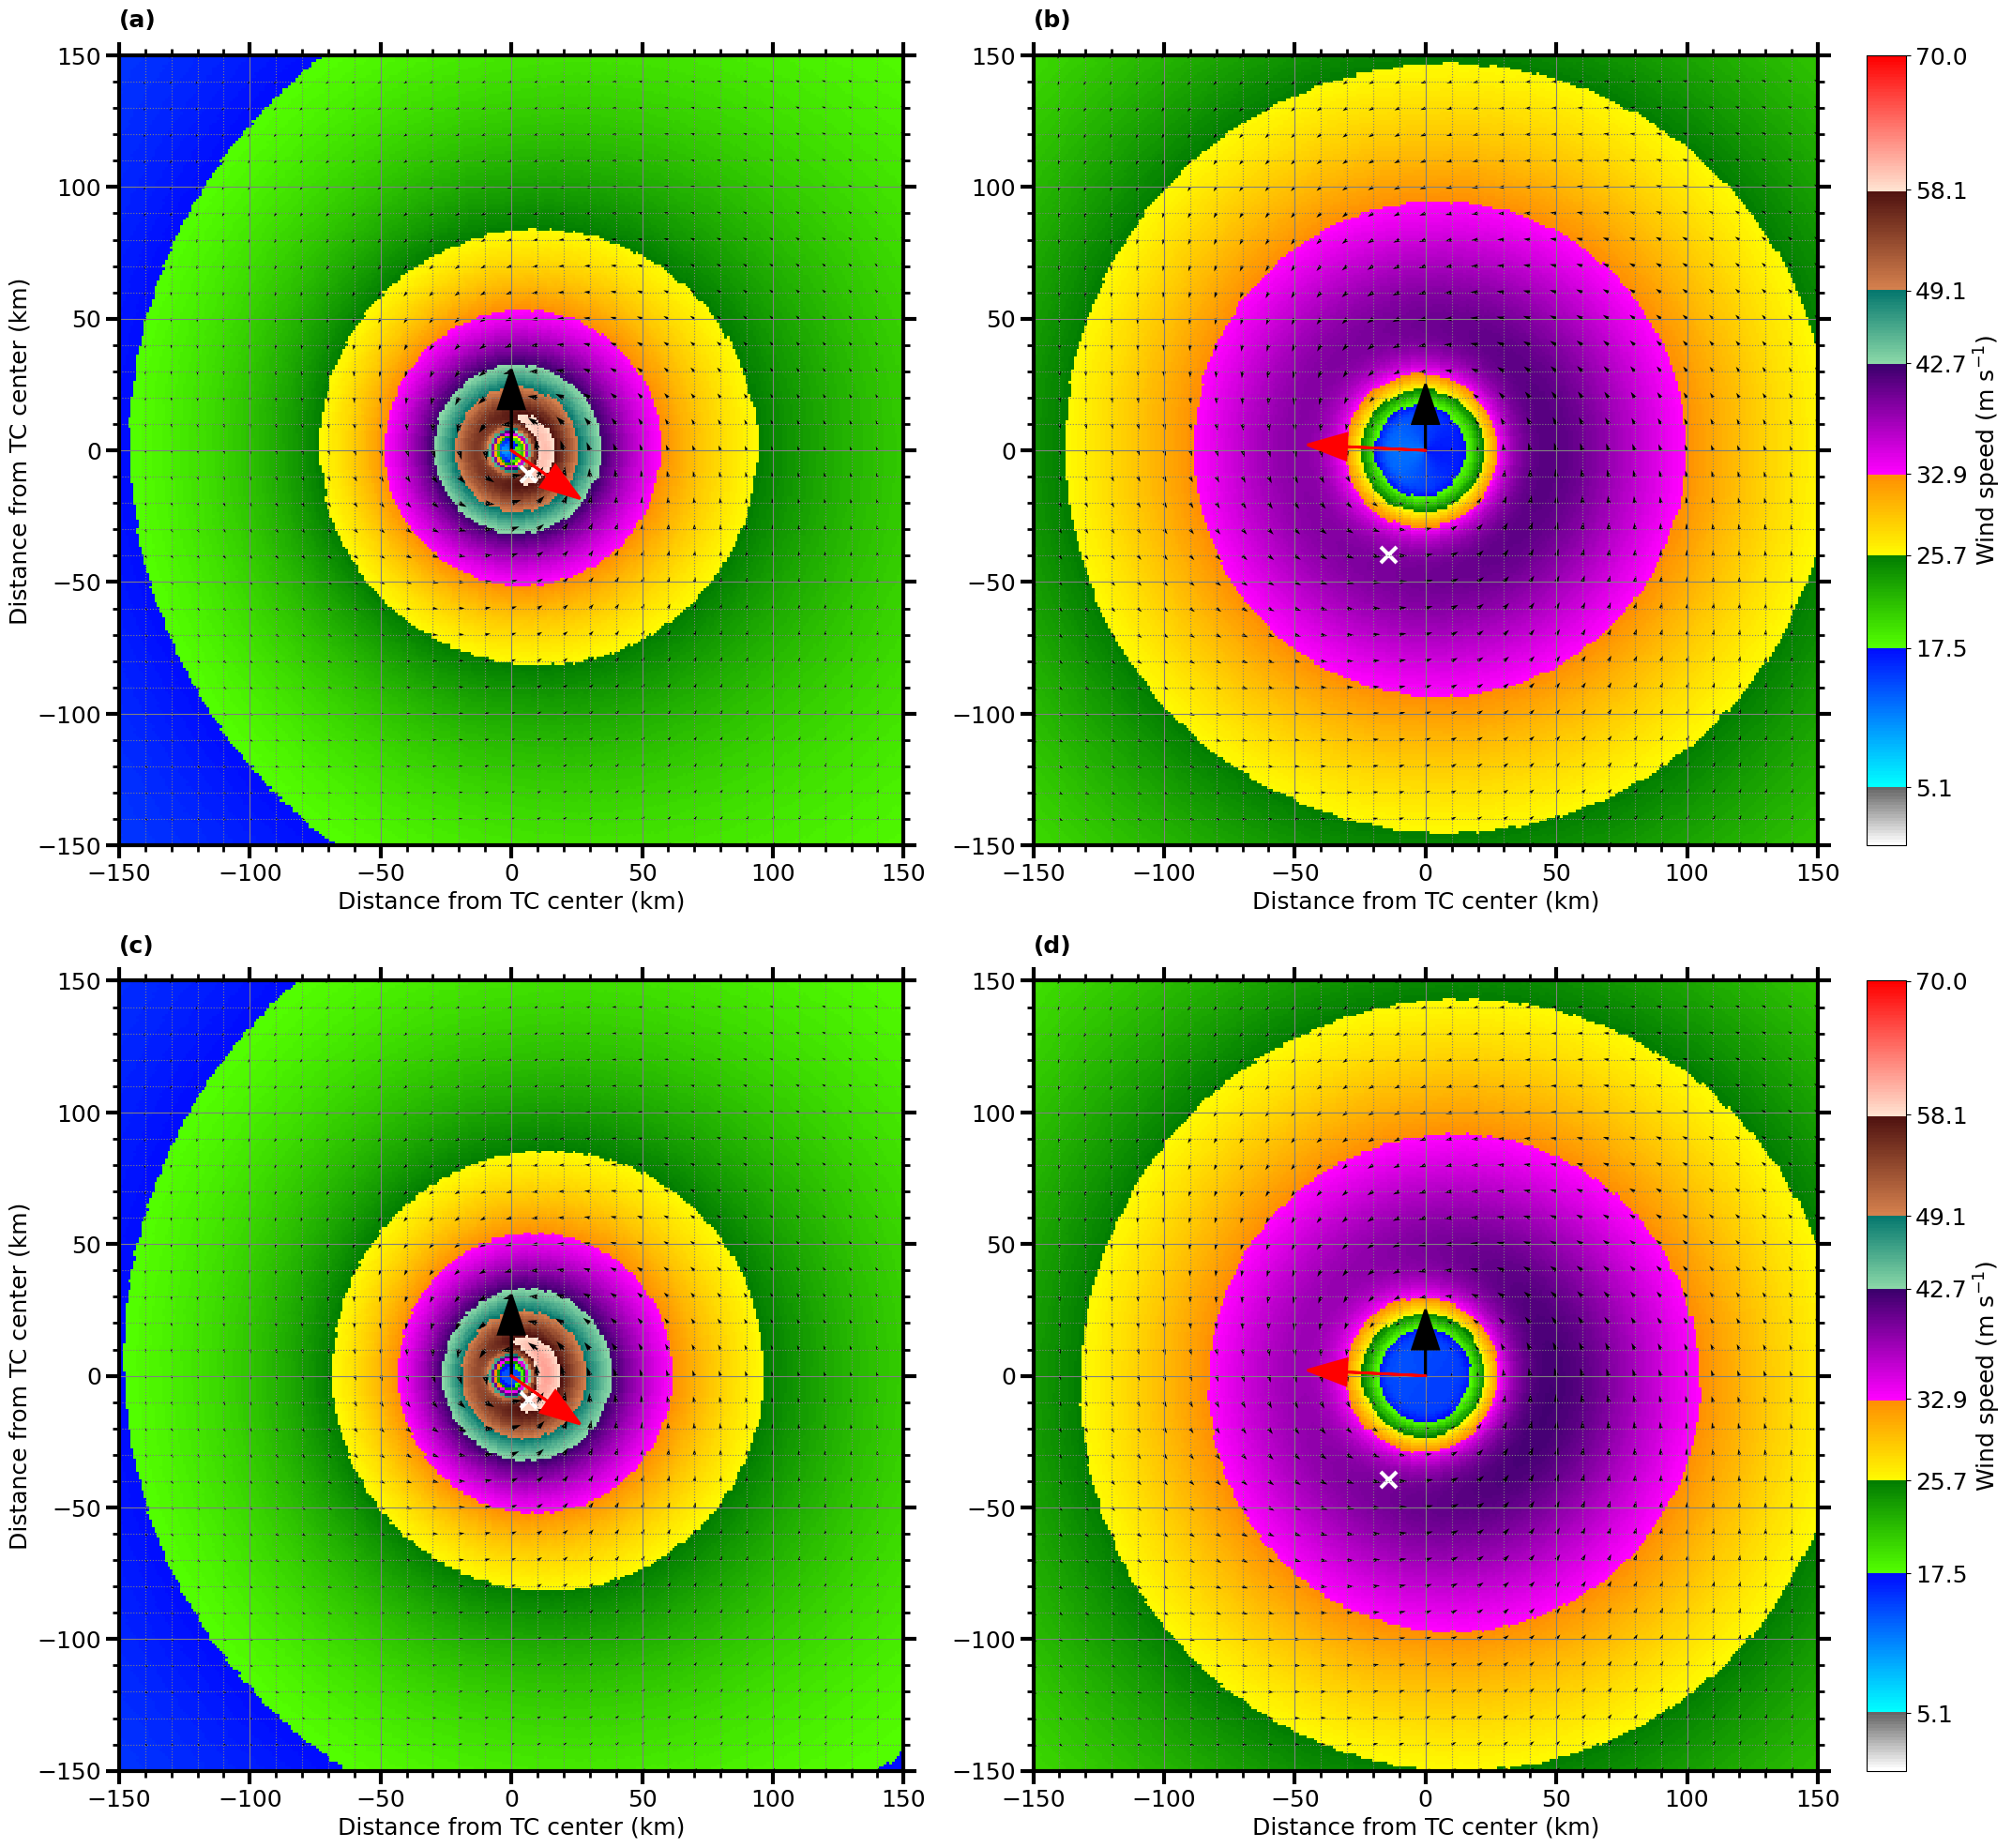

In [33]:
# Create figure with subplots
fig = plt.figure(figsize=(22, 20))
gs  = GridSpec(2, 2, width_ratios=[1, 1.25])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax_lims2D  = 150

#######################
### K01 PRM A SPEED ###
#######################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax1.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01pA, cmap=cwnd, norm=normalizer)
ax1.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01pA, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax1.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk01pA[::step, ::step], Vk01pA[::step, ::step], color='k', scale=4000)

# Motion vector
ax1.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseA.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)    
# Shear direction
ax1.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsa) / 1000,                # dx: 50 km (points right)
    float(ysa) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax1.scatter(xma / 1000, yma / 1000, marker='x', s=150, c='white', linewidth=3)

ax1.set_xlim(-ax_lims2D, ax_lims2D);ax1.set_ylim(-ax_lims2D, ax_lims2D)
ax1.set_xlabel('Distance from TC center (km)')
ax1.set_ylabel('Distance from TC center (km)')

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

#######################
### K01 PRM B SPEED ###
#######################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax2.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01pB, cmap=cwnd, norm=normalizer)
ax2.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01pB, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax2.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk01pB[::step, ::step], Vk01pB[::step, ::step], color='k', scale=4000)

# Motion vector
ax2.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseB.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)   
# Shear direction
ax2.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsb) / 1000,                # dx: 50 km (points right)
    float(ysb) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax2.scatter(xmb / 1000, ymb / 1000, marker='x', s=150, c='white', linewidth=3)

ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.set_xlabel('Distance from TC center (km)')

cbar = plt.colorbar(im1, ax=ax2, ticks=ticks_cyclobs)
cbar.set_label(r'Wind speed (m s$^{-1}$)')
cbar.set_ticklabels([round(tick, 1) for tick in ticks_cyclobs])

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)

#######################
### K25 PRM A SPEED ###
#######################
ax3.text(0.0, 1.03, '(c)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax3.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25pA, cmap=cwnd, norm=normalizer)
ax3.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25pA, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax3.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk25pA[::step, ::step], Vk25pA[::step, ::step], color='k', scale=4000)

# Motion vector
ax3.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseA.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)    
# Shear direction
ax3.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsa) / 1000,                # dx: 50 km (points right)
    float(ysa) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax3.scatter(xma / 1000, yma / 1000, marker='x', s=150, c='white', linewidth=3)

ax3.set_xlim(-ax_lims2D, ax_lims2D);ax3.set_ylim(-ax_lims2D, ax_lims2D)
ax3.set_xlabel('Distance from TC center (km)')
ax3.set_ylabel('Distance from TC center (km)')

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)

#######################
### K25 PRM B SPEED ###
#######################
ax4.text(0.0, 1.03, '(d)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax4.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25pB, cmap=cwnd, norm=normalizer)
ax4.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25pB, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax4.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk25pB[::step, ::step], Vk25pB[::step, ::step], color='k', scale=4000)

# Motion vector
ax4.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseB.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)   
# Shear direction
ax4.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsb) / 1000,                # dx: 50 km (points right)
    float(ysb) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax4.scatter(xmb / 1000, ymb / 1000, marker='x', s=150, c='white', linewidth=3)

ax4.set_xlim(-ax_lims2D, ax_lims2D);ax4.set_ylim(-ax_lims2D, ax_lims2D)
ax4.set_xlabel('Distance from TC center (km)')

cbar = plt.colorbar(im1, ax=ax4, ticks=ticks_cyclobs)
cbar.set_label(r'Wind speed (m s$^{-1}$)')
cbar.set_ticklabels([round(tick, 1) for tick in ticks_cyclobs])

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Final adjustments
plt.tight_layout()

# # Save
# plt.savefig(PTHS['sav_dir'] + 'KXX_PRM_cases_winds.png', bbox_inches='tight')

### 3) KXX_FIT winds

In [34]:
# Open datasets
k01fA      = xr.open_dataset(PTHS['K01_FIT_dir'] + '{}.nc'.format(fileA[:-17])).sel(z=10)
k01fB      = xr.open_dataset(PTHS['K01_FIT_dir'] + '{}.nc'.format(fileB[:-17])).sel(z=10)
k25fA      = xr.open_dataset(PTHS['K25_FIT_dir'] + '{}.nc'.format(fileA[:-17])).sel(z=10)
k25fB      = xr.open_dataset(PTHS['K25_FIT_dir'] + '{}.nc'.format(fileB[:-17])).sel(z=10)

In [35]:
# Convert to cartesian datasets and compute zonal (U) and meridional (V) wind components
Vtot_k01fA = get_cartesian_var_from_kepert(k01fA, 'wind_speed')
Vrad_k01fA = get_cartesian_var_from_kepert(k01fA, 'rad_wind')
Vtan_k01fA = get_cartesian_var_from_kepert(k01fA, 'tan_wind')
Uk01fA     = Vrad_k01fA * np.cos(alpha) - Vtan_k01fA * np.sin(alpha)
Vk01fA     = Vrad_k01fA * np.sin(alpha) + Vtan_k01fA * np.cos(alpha)
print('Case A K01 FIT converted.')

Vtot_k01fB = get_cartesian_var_from_kepert(k01fB, 'wind_speed')
Vrad_k01fB = get_cartesian_var_from_kepert(k01fB, 'rad_wind')
Vtan_k01fB = get_cartesian_var_from_kepert(k01fB, 'tan_wind')
Uk01fB     = Vrad_k01fB * np.cos(alpha) - Vtan_k01fB * np.sin(alpha)
Vk01fB     = Vrad_k01fB * np.sin(alpha) + Vtan_k01fB * np.cos(alpha)
print('Case B K01 FIT converted.')

Vtot_k25fA = get_cartesian_var_from_kepert(k25fA, 'wind_speed')
Vrad_k25fA = get_cartesian_var_from_kepert(k25fA, 'rad_wind')
Vtan_k25fA = get_cartesian_var_from_kepert(k25fA, 'tan_wind')
Uk25fA     = Vrad_k25fA * np.cos(alpha) - Vtan_k25fA * np.sin(alpha)
Vk25fA     = Vrad_k25fA * np.sin(alpha) + Vtan_k25fA * np.cos(alpha)
print('Case A K25 FIT converted.')

Vtot_k25fB = get_cartesian_var_from_kepert(k25fB, 'wind_speed')
Vrad_k25fB = get_cartesian_var_from_kepert(k25fB, 'rad_wind')
Vtan_k25fB = get_cartesian_var_from_kepert(k25fB, 'tan_wind')
Uk25fB     = Vrad_k25fB * np.cos(alpha) - Vtan_k25fB * np.sin(alpha)
Vk25fB     = Vrad_k25fB * np.sin(alpha) + Vtan_k25fB * np.cos(alpha)
print('Case B K25 FIT converted.')

Case A K01 FIT converted.
Case B K01 FIT converted.
Case A K25 FIT converted.
Case B K25 FIT converted.


/tmp/ipykernel_8621/3414703803.py:107: UserWarning: Adding colorbar to a different Figure <Figure size 2200x1000 with 3 Axes> than <Figure size 2200x2000 with 5 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im1, ax=ax2, ticks=ticks_cyclobs)
/tmp/ipykernel_8621/3414703803.py:218: UserWarning: Adding colorbar to a different Figure <Figure size 2200x1000 with 3 Axes> than <Figure size 2200x2000 with 6 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im1, ax=ax4, ticks=ticks_cyclobs)


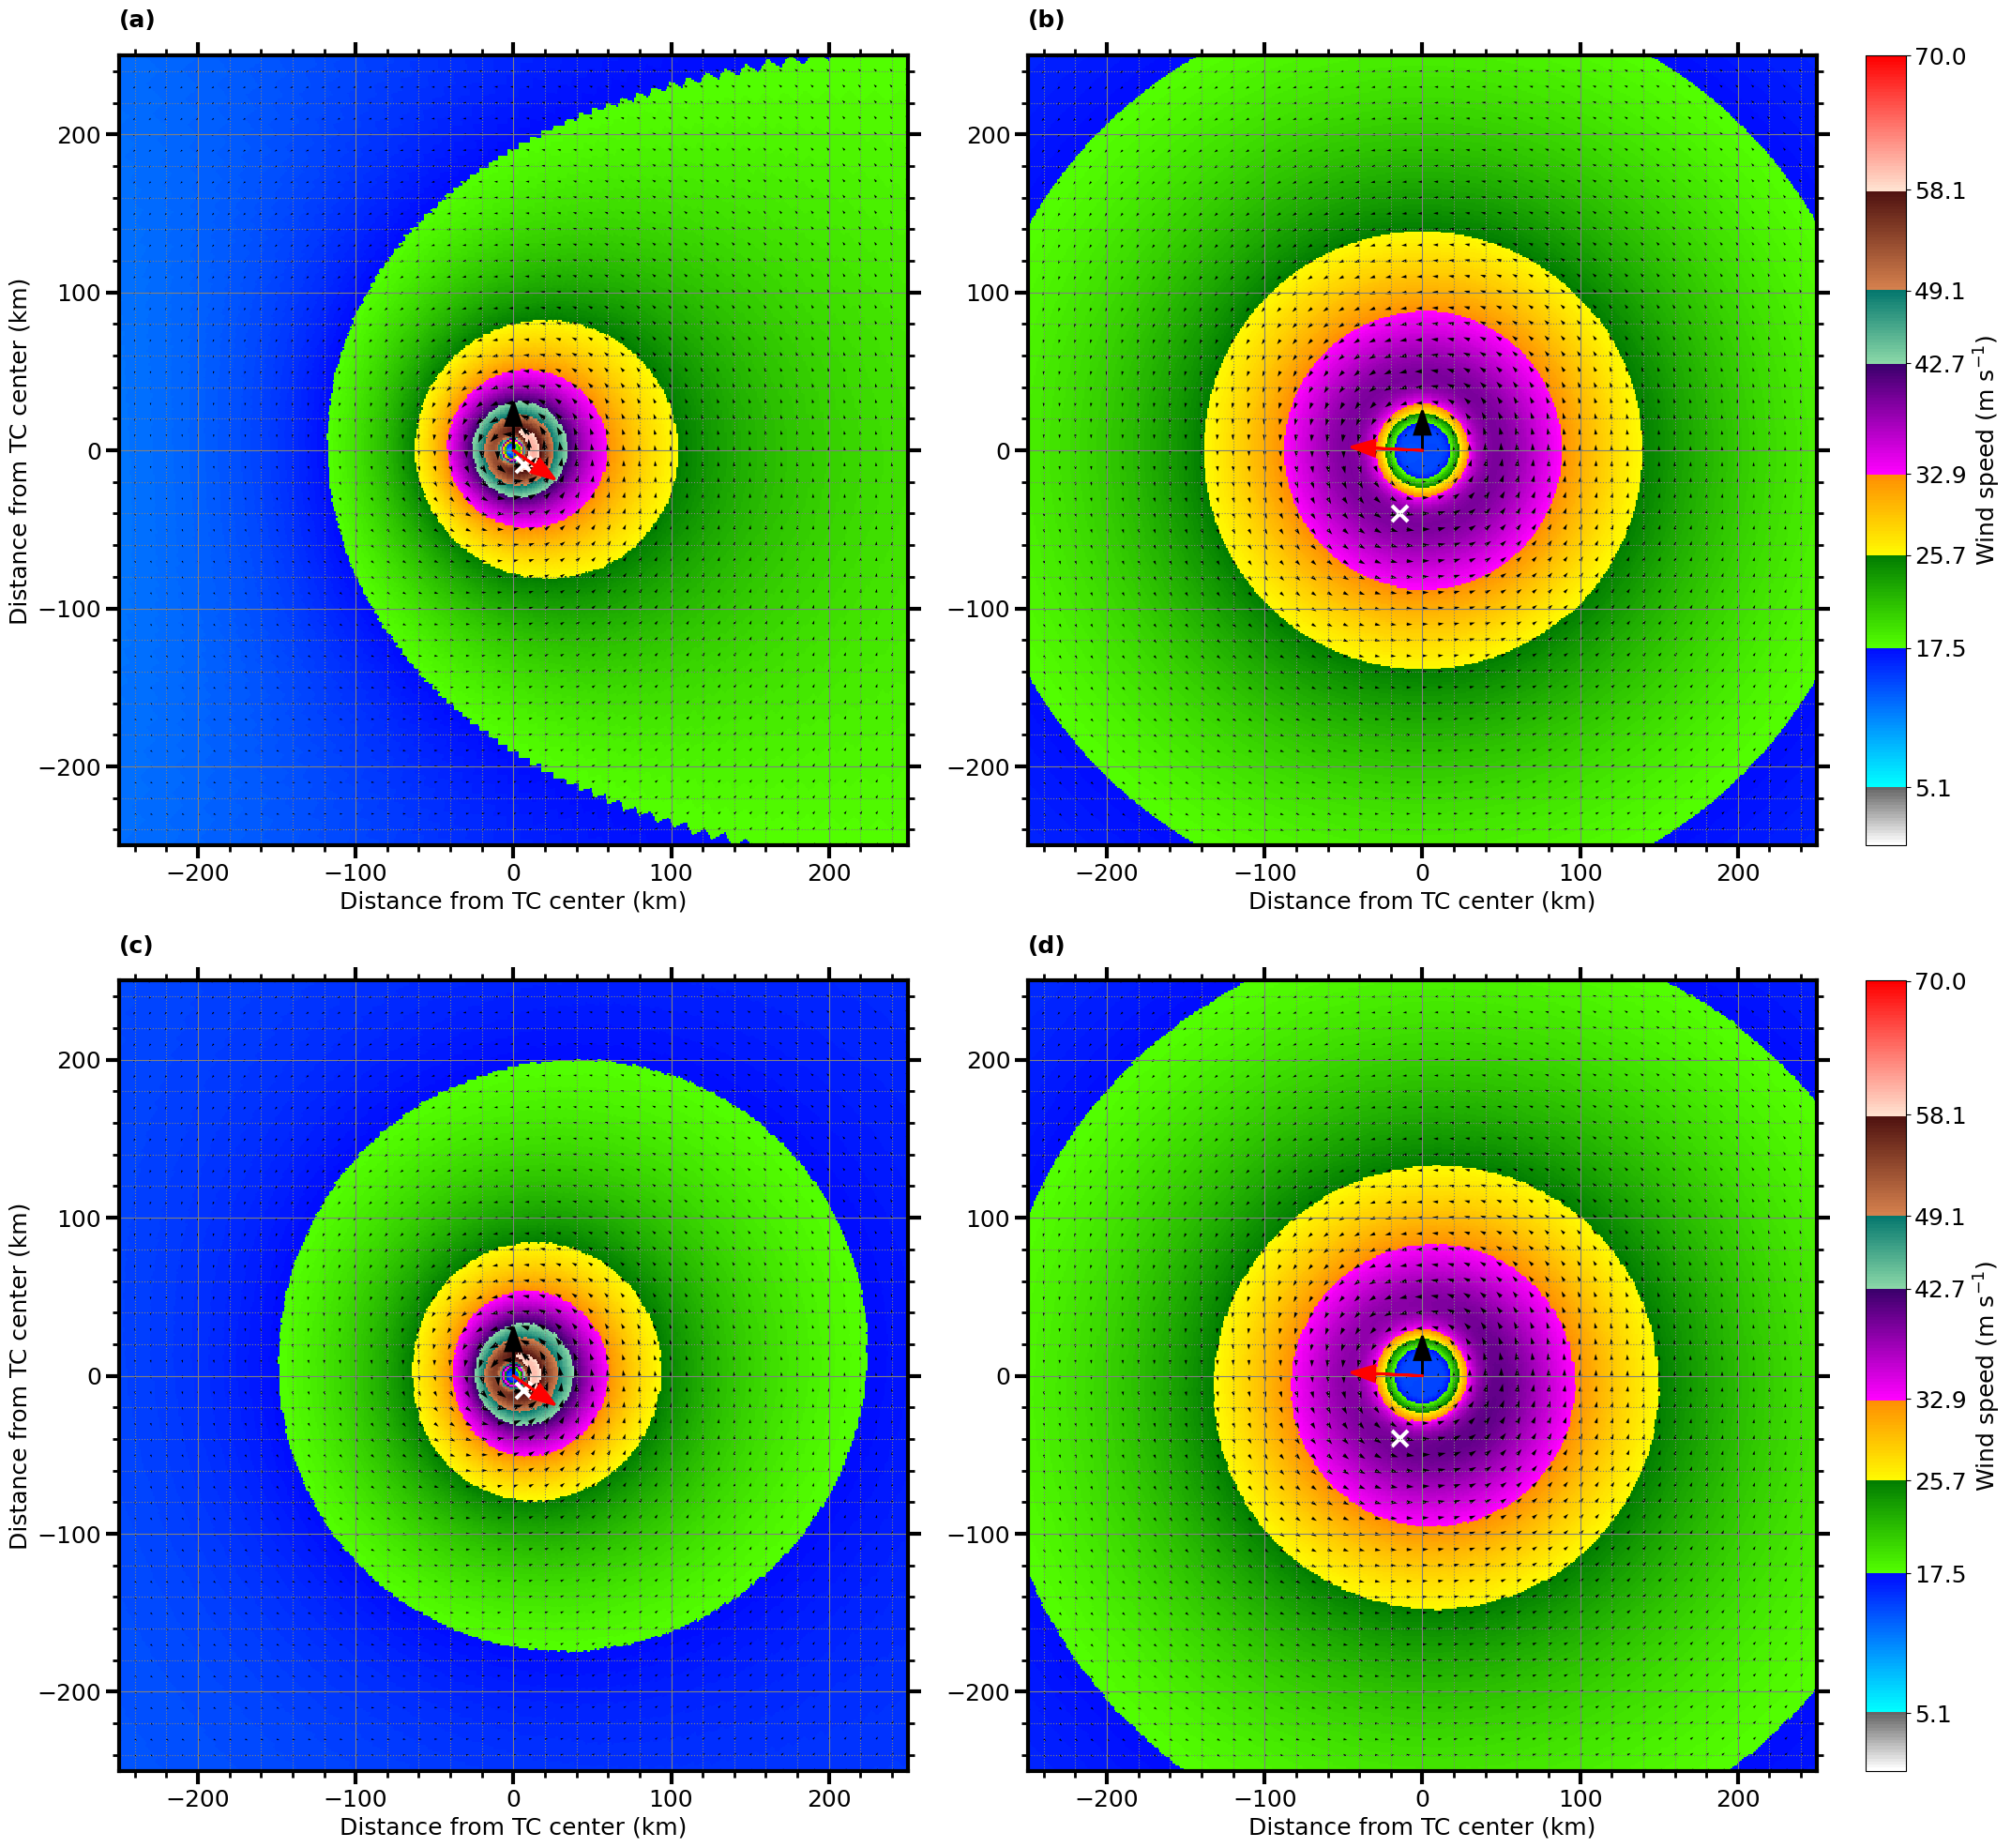

In [36]:
# Create figure with subplots
fig = plt.figure(figsize=(22, 20))
gs  = GridSpec(2, 2, width_ratios=[1, 1.25])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax_lims2D  = 150

#######################
### K01 PRM A SPEED ###
#######################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax1.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01fA, cmap=cwnd, norm=normalizer)
ax1.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01fA, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax1.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk01fA[::step, ::step], Vk01fA[::step, ::step], color='k', scale=4000)

# Motion vector
ax1.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseA.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)    
# Shear direction
ax1.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsa) / 1000,                # dx: 50 km (points right)
    float(ysa) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax1.scatter(xma / 1000, yma / 1000, marker='x', s=150, c='white', linewidth=3)

ax1.set_xlim(-ax_lims2D, ax_lims2D);ax1.set_ylim(-ax_lims2D, ax_lims2D)
ax1.set_xlabel('Distance from TC center (km)')
ax1.set_ylabel('Distance from TC center (km)')

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

#######################
### K01 PRM B SPEED ###
#######################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax2.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01fB, cmap=cwnd, norm=normalizer)
ax2.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01fB, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax2.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk01fB[::step, ::step], Vk01fB[::step, ::step], color='k', scale=4000)

# Motion vector
ax2.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseB.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)   
# Shear direction
ax2.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsb) / 1000,                # dx: 50 km (points right)
    float(ysb) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax2.scatter(xmb / 1000, ymb / 1000, marker='x', s=150, c='white', linewidth=3)

ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.set_xlabel('Distance from TC center (km)')

cbar = plt.colorbar(im1, ax=ax2, ticks=ticks_cyclobs)
cbar.set_label(r'Wind speed (m s$^{-1}$)')
cbar.set_ticklabels([round(tick, 1) for tick in ticks_cyclobs])

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)

#######################
### K25 PRM A SPEED ###
#######################
ax3.text(0.0, 1.03, '(c)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax3.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25fA, cmap=cwnd, norm=normalizer)
ax3.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25fA, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax3.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk25fA[::step, ::step], Vk25fA[::step, ::step], color='k', scale=4000)

# Motion vector
ax3.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseA.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)    
# Shear direction
ax3.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsa) / 1000,                # dx: 50 km (points right)
    float(ysa) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax3.scatter(xma / 1000, yma / 1000, marker='x', s=150, c='white', linewidth=3)

ax3.set_xlim(-ax_lims2D, ax_lims2D);ax3.set_ylim(-ax_lims2D, ax_lims2D)
ax3.set_xlabel('Distance from TC center (km)')
ax3.set_ylabel('Distance from TC center (km)')

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)

#######################
### K25 PRM B SPEED ###
#######################
ax4.text(0.0, 1.03, '(d)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax4.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25fB, cmap=cwnd, norm=normalizer)
ax4.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25fB, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax4.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk25fB[::step, ::step], Vk25fB[::step, ::step], color='k', scale=4000)

# Motion vector
ax4.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseB.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)   
# Shear direction
ax4.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsb) / 1000,                # dx: 50 km (points right)
    float(ysb) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax4.scatter(xmb / 1000, ymb / 1000, marker='x', s=150, c='white', linewidth=3)

ax4.set_xlim(-ax_lims2D, ax_lims2D);ax4.set_ylim(-ax_lims2D, ax_lims2D)
ax4.set_xlabel('Distance from TC center (km)')

cbar = plt.colorbar(im1, ax=ax4, ticks=ticks_cyclobs)
cbar.set_label(r'Wind speed (m s$^{-1}$)')
cbar.set_ticklabels([round(tick, 1) for tick in ticks_cyclobs])

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Final adjustments
plt.tight_layout()

# # Save
# plt.savefig(PTHS['sav_dir'] + 'KXX_FIT_cases_winds.png', bbox_inches='tight')

### 4) KXX_wIA winds

In [75]:
# Open datasets
k01iA      = xr.open_dataset(PTHS['K01_wIA_dir'] + '{}.nc'.format(fileA[:-17])).sel(z=10)
k01iB      = xr.open_dataset(PTHS['K01_wIA_dir'] + '{}.nc'.format(fileB[:-17])).sel(z=10)
k25iA      = xr.open_dataset(PTHS['K25_wIA_dir'] + '{}.nc'.format(fileA[:-17])).sel(z=10)
k25iB      = xr.open_dataset(PTHS['K25_wIA_dir'] + '{}.nc'.format(fileB[:-17])).sel(z=10)

In [76]:
# Convert to cartesian datasets and compute zonal (U) and meridional (V) wind components
Vtot_k01iA = get_cartesian_var_from_kepert(k01iA, 'wind_speed')
Vrad_k01iA = get_cartesian_var_from_kepert(k01iA, 'rad_wind')
Vtan_k01iA = get_cartesian_var_from_kepert(k01iA, 'tan_wind')
Uk01iA     = Vrad_k01iA * np.cos(alpha) - Vtan_k01iA * np.sin(alpha)
Vk01iA     = Vrad_k01iA * np.sin(alpha) + Vtan_k01iA * np.cos(alpha)
print('Case A K01 wIA converted.')

Vtot_k01iB = get_cartesian_var_from_kepert(k01iB, 'wind_speed')
Vrad_k01iB = get_cartesian_var_from_kepert(k01iB, 'rad_wind')
Vtan_k01iB = get_cartesian_var_from_kepert(k01iB, 'tan_wind')
Uk01iB     = Vrad_k01iB * np.cos(alpha) - Vtan_k01iB * np.sin(alpha)
Vk01iB     = Vrad_k01iB * np.sin(alpha) + Vtan_k01iB * np.cos(alpha)
print('Case B K01 wIA converted.')

Vtot_k25iA = get_cartesian_var_from_kepert(k25iA, 'wind_speed')
Vrad_k25iA = get_cartesian_var_from_kepert(k25iA, 'rad_wind')
Vtan_k25iA = get_cartesian_var_from_kepert(k25iA, 'tan_wind')
Uk25iA     = Vrad_k25iA * np.cos(alpha) - Vtan_k25iA * np.sin(alpha)
Vk25iA     = Vrad_k25iA * np.sin(alpha) + Vtan_k25iA * np.cos(alpha)
print('Case A K25 wIA converted.')

Vtot_k25iB = get_cartesian_var_from_kepert(k25iB, 'wind_speed')
Vrad_k25iB = get_cartesian_var_from_kepert(k25iB, 'rad_wind')
Vtan_k25iB = get_cartesian_var_from_kepert(k25iB, 'tan_wind')
Uk25iB     = Vrad_k25iB * np.cos(alpha) - Vtan_k25iB * np.sin(alpha)
Vk25iB     = Vrad_k25iB * np.sin(alpha) + Vtan_k25iB * np.cos(alpha)
print('Case B K25 wIA converted.')

Case A K01 wIA converted.
Case B K01 wIA converted.
Case A K25 wIA converted.
Case B K25 wIA converted.


/tmp/ipykernel_5624/99229176.py:107: UserWarning: Adding colorbar to a different Figure <Figure size 2200x1000 with 3 Axes> than <Figure size 2200x2000 with 5 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im1, ax=ax2, ticks=ticks_cyclobs)
/tmp/ipykernel_5624/99229176.py:218: UserWarning: Adding colorbar to a different Figure <Figure size 2200x1000 with 3 Axes> than <Figure size 2200x2000 with 6 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im1, ax=ax4, ticks=ticks_cyclobs)


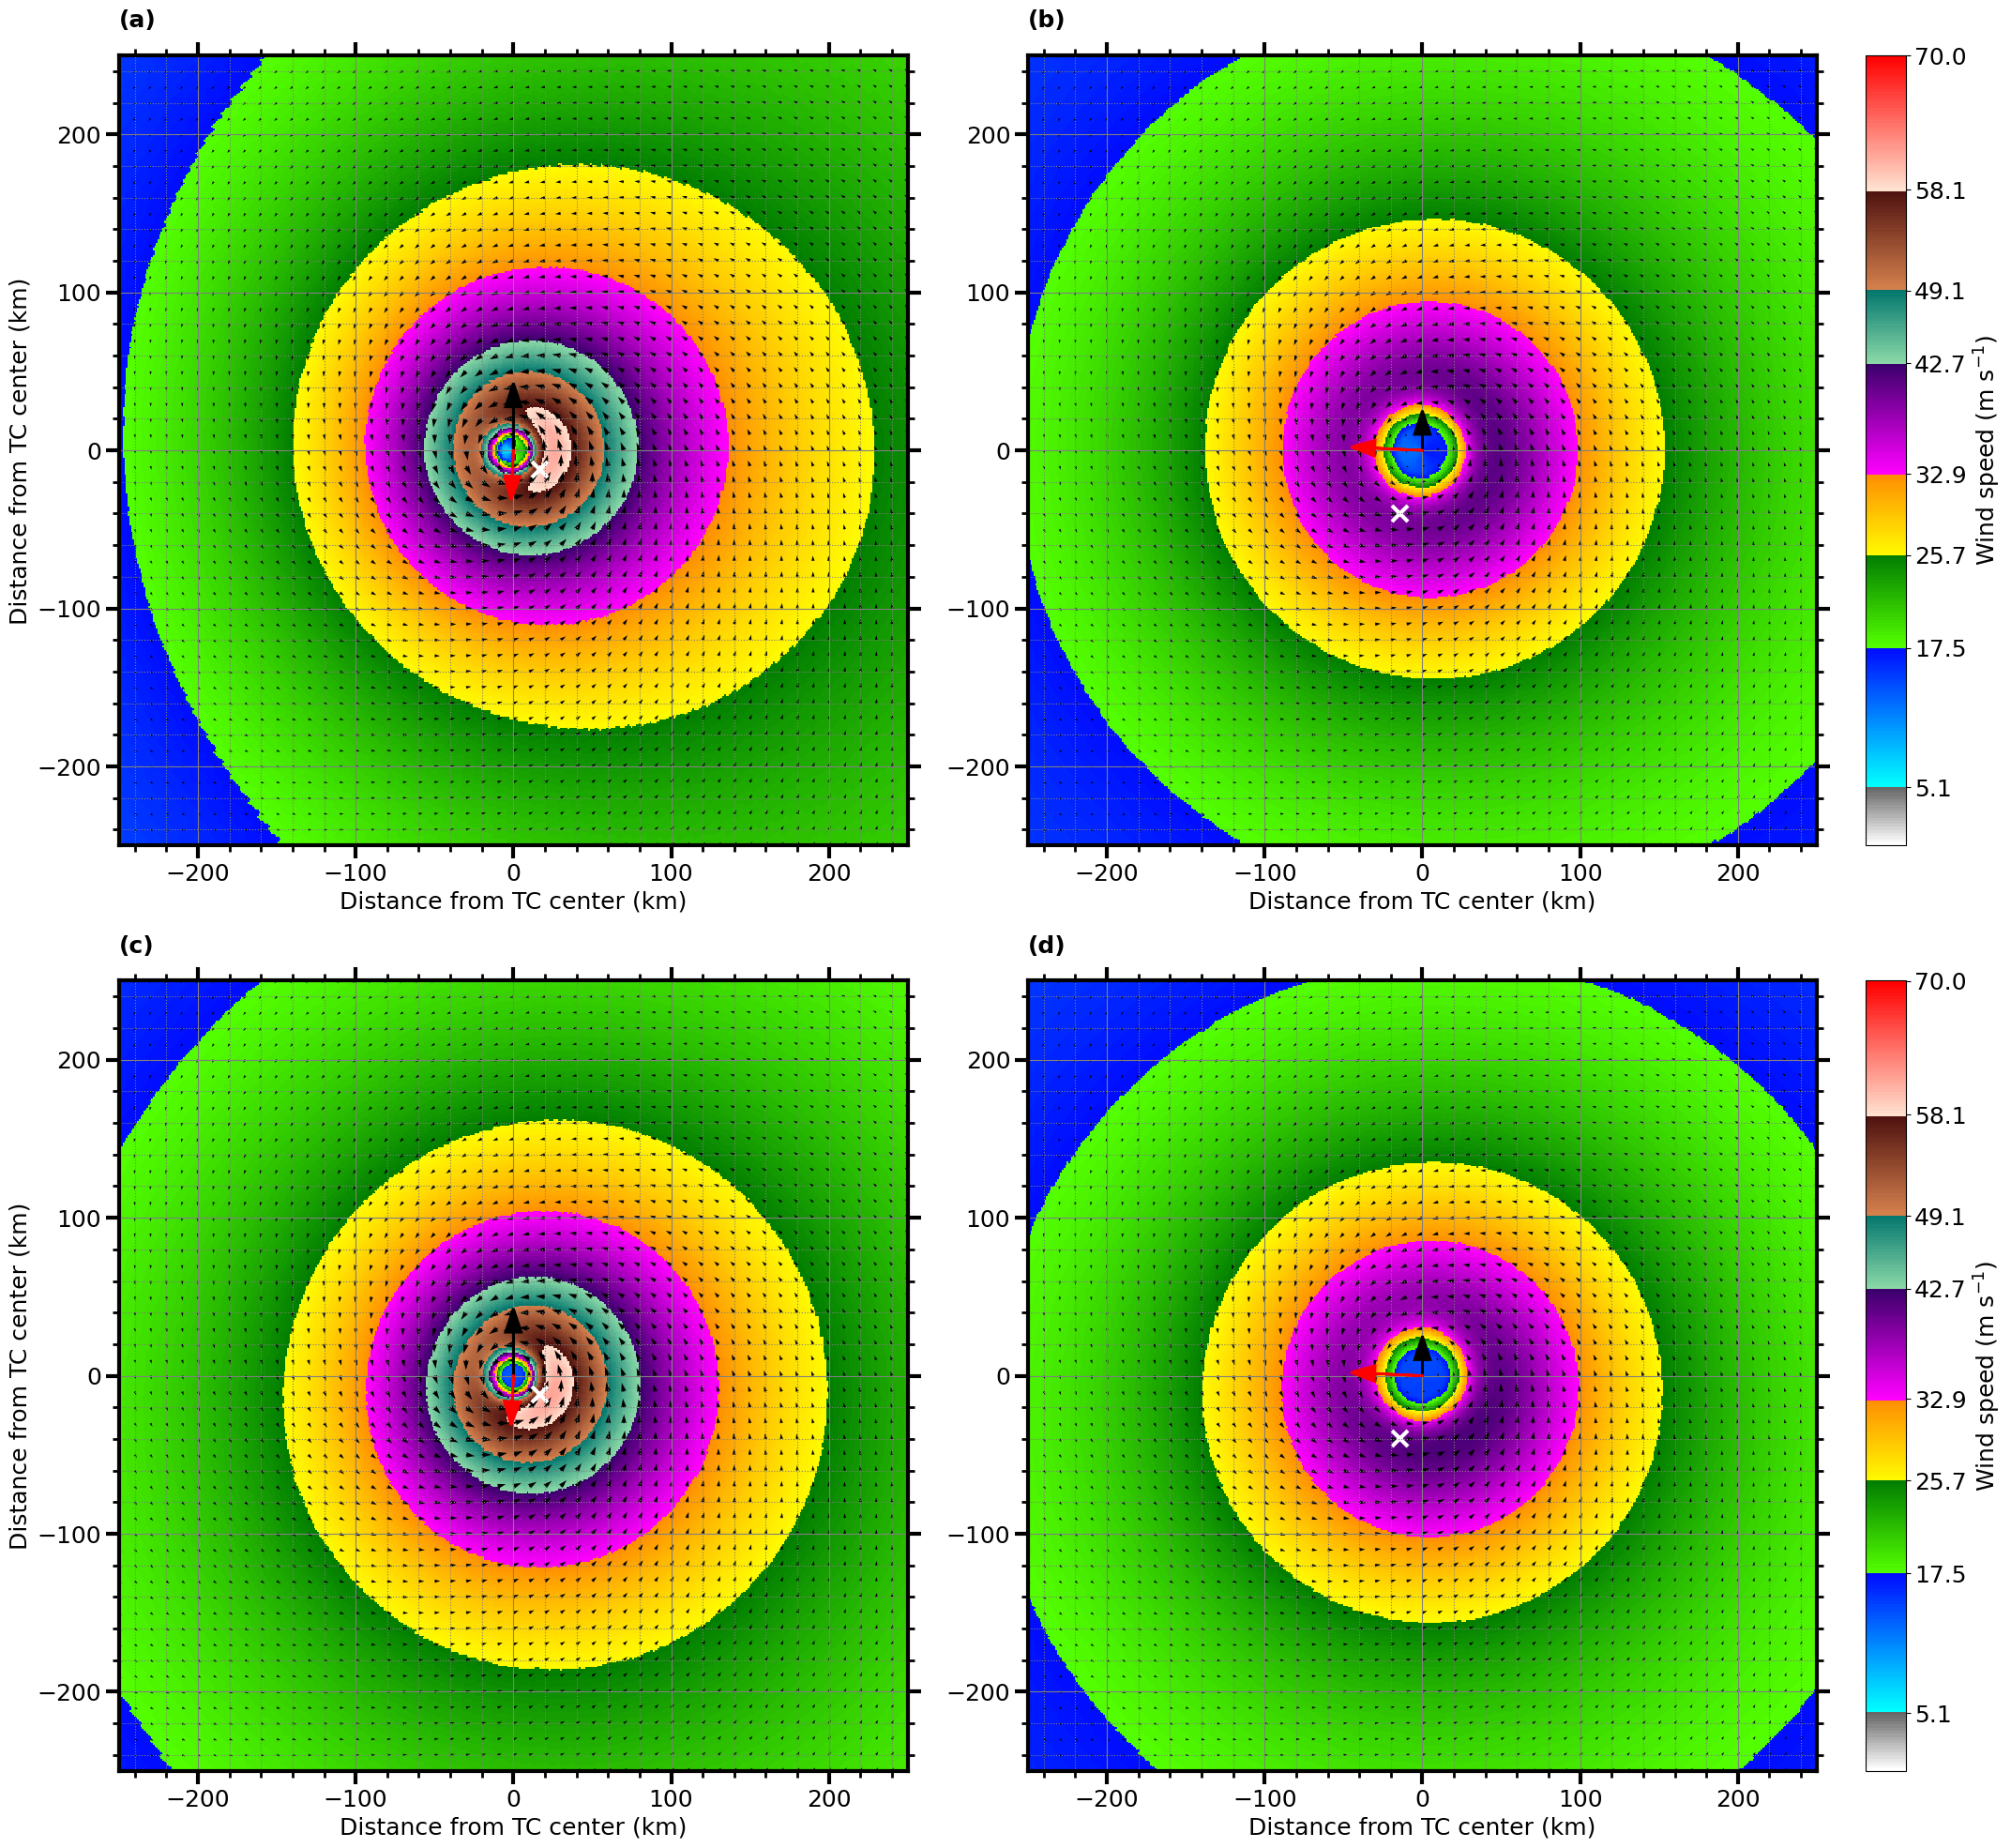

In [77]:
# Create figure with subplots
fig = plt.figure(figsize=(22, 20))
gs  = GridSpec(2, 2, width_ratios=[1, 1.25])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax_lims2D  = 150

#######################
### K01 PRM A SPEED ###
#######################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax1.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01iA, cmap=cwnd, norm=normalizer)
ax1.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01iA, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax1.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk01iA[::step, ::step], Vk01iA[::step, ::step], color='k', scale=4000)

# Motion vector
ax1.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseA.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)    
# Shear direction
ax1.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsa) / 1000,                # dx: 50 km (points right)
    float(ysa) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax1.scatter(xma / 1000, yma / 1000, marker='x', s=150, c='white', linewidth=3)

ax1.set_xlim(-ax_lims2D, ax_lims2D);ax1.set_ylim(-ax_lims2D, ax_lims2D)
ax1.set_xlabel('Distance from TC center (km)')
ax1.set_ylabel('Distance from TC center (km)')

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

#######################
### K01 PRM B SPEED ###
#######################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax2.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01iB, cmap=cwnd, norm=normalizer)
ax2.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k01iB, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax2.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk01iB[::step, ::step], Vk01iB[::step, ::step], color='k', scale=4000)

# Motion vector
ax2.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseB.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)   
# Shear direction
ax2.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsb) / 1000,                # dx: 50 km (points right)
    float(ysb) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax2.scatter(xmb / 1000, ymb / 1000, marker='x', s=150, c='white', linewidth=3)

ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.set_xlabel('Distance from TC center (km)')

cbar = plt.colorbar(im1, ax=ax2, ticks=ticks_cyclobs)
cbar.set_label(r'Wind speed (m s$^{-1}$)')
cbar.set_ticklabels([round(tick, 1) for tick in ticks_cyclobs])

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)

#######################
### K25 PRM A SPEED ###
#######################
ax3.text(0.0, 1.03, '(c)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax3.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25iA, cmap=cwnd, norm=normalizer)
ax3.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25iA, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax3.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk25iA[::step, ::step], Vk25iA[::step, ::step], color='k', scale=4000)

# Motion vector
ax3.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseA.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)    
# Shear direction
ax3.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsa) / 1000,                # dx: 50 km (points right)
    float(ysa) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax3.scatter(xma / 1000, yma / 1000, marker='x', s=150, c='white', linewidth=3)

ax3.set_xlim(-ax_lims2D, ax_lims2D);ax3.set_ylim(-ax_lims2D, ax_lims2D)
ax3.set_xlabel('Distance from TC center (km)')
ax3.set_ylabel('Distance from TC center (km)')

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)

#######################
### K25 PRM B SPEED ###
#######################
ax4.text(0.0, 1.03, '(d)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# K01 wind speeds
# ax4.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25iB, cmap=cwnd, norm=normalizer)
ax4.pcolormesh(x_ref / 1000, y_ref / 1000, Vtot_k25iB, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
ax4.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, Uk25iB[::step, ::step], Vk25iB[::step, ::step], color='k', scale=4000)

# Motion vector
ax4.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseB.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)   
# Shear direction
ax4.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsb) / 1000,                # dx: 50 km (points right)
    float(ysb) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax4.scatter(xmb / 1000, ymb / 1000, marker='x', s=150, c='white', linewidth=3)

ax4.set_xlim(-ax_lims2D, ax_lims2D);ax4.set_ylim(-ax_lims2D, ax_lims2D)
ax4.set_xlabel('Distance from TC center (km)')

cbar = plt.colorbar(im1, ax=ax4, ticks=ticks_cyclobs)
cbar.set_label(r'Wind speed (m s$^{-1}$)')
cbar.set_ticklabels([round(tick, 1) for tick in ticks_cyclobs])

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Final adjustments
plt.tight_layout()

# # Save
# plt.savefig(PTHS['sav_dir'] + 'KXX_wIA_cases_winds.png', bbox_inches='tight')

### 5) HY2 winds

In [62]:
# Open files
sctCarA = xr.open_dataset('/home/arthur/data/tropical_cyclones/scatterometer/hy-2/cartesian/hy-2b/2023/146/CAR_hscat_20230526_073810_hy_2b__23015_o_250_2204_ovw_l2_wp022023.nc')
sctCarB = xr.open_dataset('/home/arthur/data/tropical_cyclones/scatterometer/hy-2/cartesian/hy-2b/2023/275/CAR_hscat_20231002_084532_hy_2b__24794_o_250_2204_ovw_l2_wp142023.nc')

In [63]:
# Common grid
x_ref_sct, y_ref_sct = np.meshgrid(sctCarA.x, sctCarA.y)
alpha_sct            = np.arctan2(y_ref_sct, x_ref_sct)
# Zonal and meridional winds
UsctA                = sctCarA.radial_wind * np.cos(alpha_sct) - sctCarA.tangential_wind * np.sin(alpha_sct)
VsctA                = sctCarA.radial_wind * np.sin(alpha_sct) + sctCarA.tangential_wind * np.cos(alpha_sct)
UsctB                = sctCarB.radial_wind * np.cos(alpha_sct) - sctCarB.tangential_wind * np.sin(alpha_sct)
VsctB                = sctCarB.radial_wind * np.sin(alpha_sct) + sctCarB.tangential_wind * np.cos(alpha_sct)

In [64]:
# # Down sample to a 1km-res.
# sctCarA = sctCarA.interp(x=dim_ref, y=dim_ref)
# sctCarB = sctCarB.interp(x=dim_ref, y=dim_ref)

In [65]:
# ### Code to get time of acquisition
# ts           = pd.to_datetime(str(sctCarA.time.values)) 
# d            = ts.strftime('%Y-%m-%d %H:%M')
# mission      = sct_pth.split('/')[8]

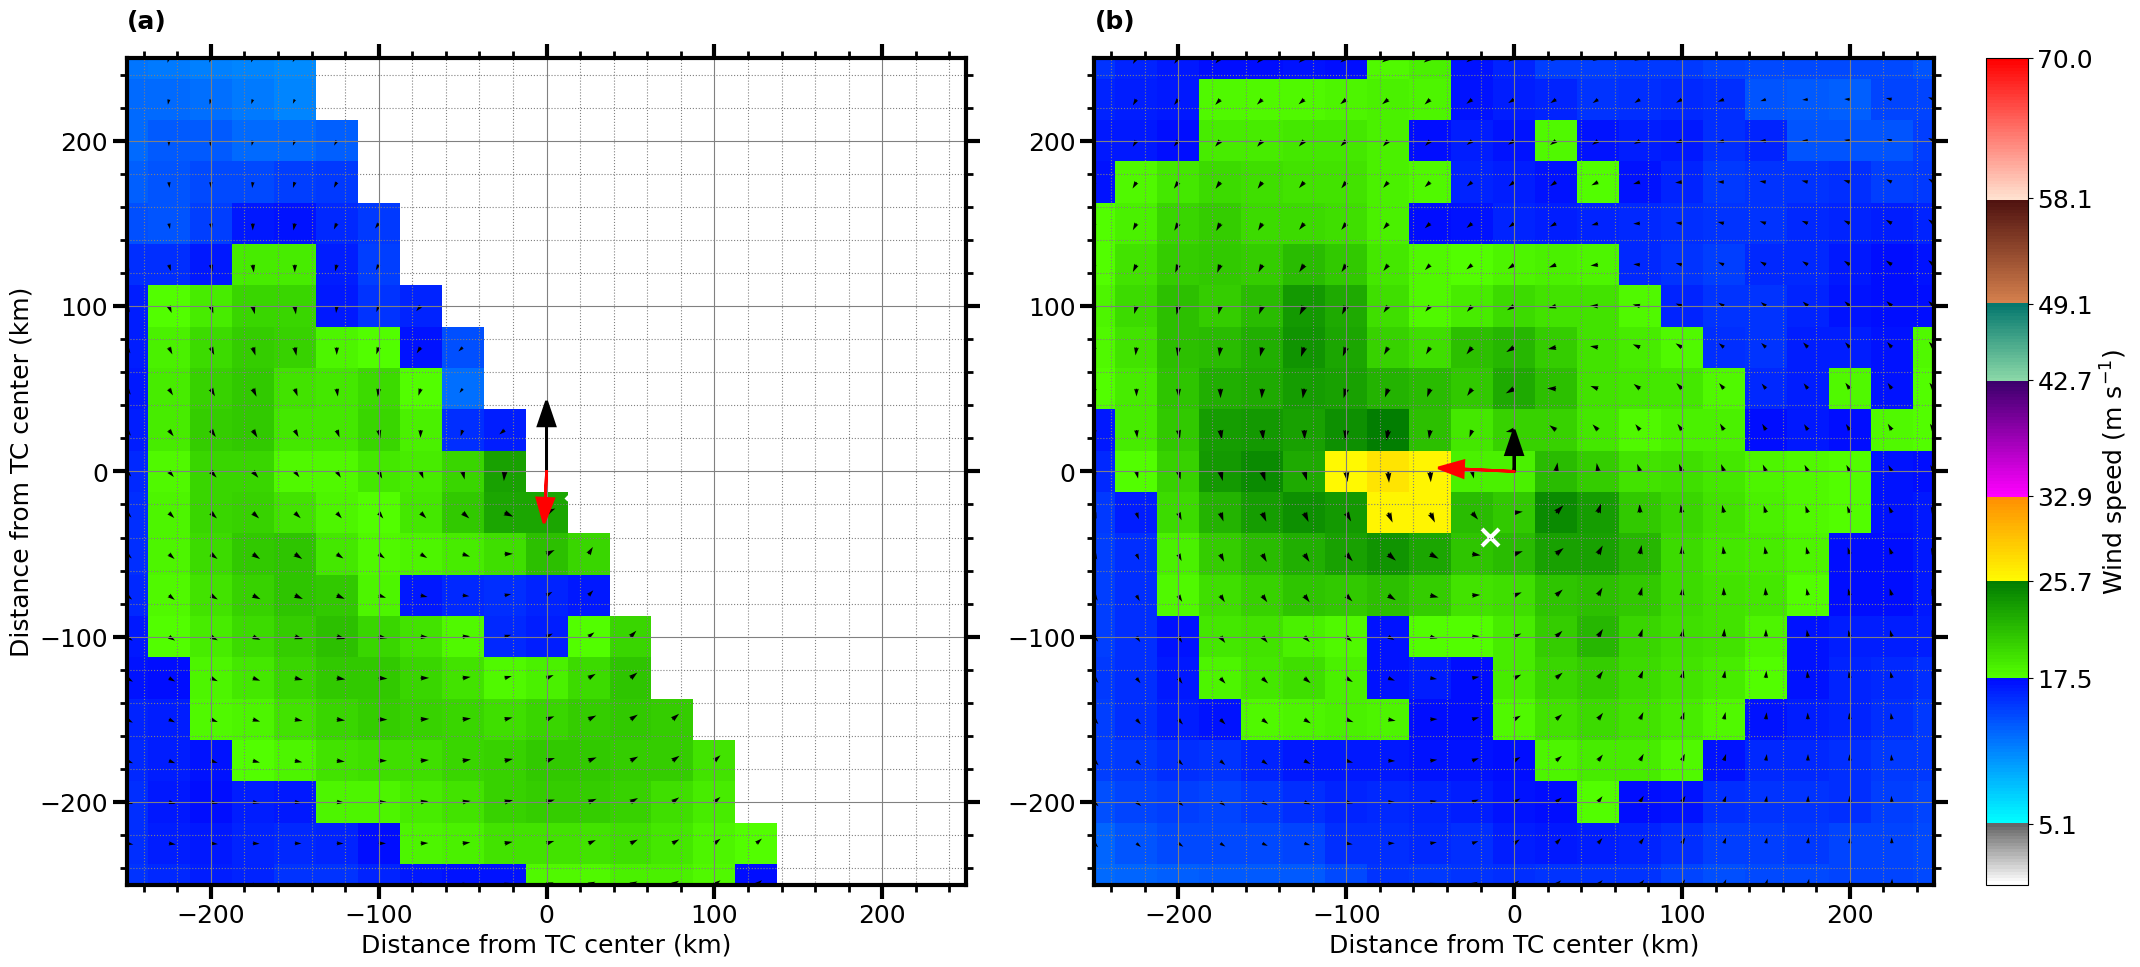

In [67]:
# Create figure with subplots
fig = plt.figure(figsize=(22, 10))
gs  = GridSpec(1, 2, width_ratios=[1, 1.25])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax_lims2D  = 150

#####################
### SCT  A  SPEED ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# SCT wind speeds
im1     = ax1.pcolormesh(x_ref_sct / 1000, y_ref_sct / 1000, sctCarA.wind_speed, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
# im1     = ax1.pcolormesh(x_ref / 1000, y_ref / 1000, sctCarA.wind_speed, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)

# SCT wind vectors
ax1.quiver(x_ref_sct[::1, ::1] / 1000, y_ref_sct[::1, ::1] / 1000, UsctA[::1, ::1], VsctA[::1, ::1], color='k', scale=2000)

# Motion vector
ax1.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseA.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)    
# Shear direction
ax1.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsa) / 1000,                # dx: 50 km (points right)
    float(ysa) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax1.scatter(xma / 1000, yma / 1000, marker='x', s=150, c='white', linewidth=3)

ax1.set_xlim(-ax_lims2D, ax_lims2D);ax1.set_ylim(-ax_lims2D, ax_lims2D)
ax1.set_xlabel('Distance from TC center (km)')
ax1.set_ylabel('Distance from TC center (km)')

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

#####################
### SCT  B  SPEED ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# SCT wind speeds
im2     = ax2.pcolormesh(x_ref_sct / 1000, y_ref_sct / 1000, sctCarB.wind_speed, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
# im2     = ax2.pcolormesh(x_ref / 1000, y_ref / 1000, sctCarB.wind_speed, cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
# SCT wind vectors
ax2.quiver(x_ref_sct[::1, ::1] / 1000, y_ref_sct[::1, ::1] / 1000, UsctB[::1, ::1], VsctB[::1, ::1], color='k', scale=2000)

# Motion vector
ax2.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    0,                                # dx: 50 km (points right)
    float(caseB.speed * 3600 / 1000), # dy: 0 km (points top)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='k',                           # Face color
    ec='k',                           # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
)   
# Shear direction
ax2.arrow(
    0,                                # x_start: 150 km
    0,                                # y_start: 200 km
    float(xsb) / 1000,                # dx: 50 km (points right)
    float(ysb) / 1000,                # dy: 0 km (horizontal)
    head_width=10,                    # Width of the arrow head
    head_length=15,                   # Length of the arrow head
    fc='r',                   # Face color
    ec='r',                   # Edge color
    linewidth=2,
    zorder=10                         # Ensure it plots over the pcolormesh
) 
# Maximum Azim. Location
ax2.scatter(xmb / 1000, ymb / 1000, marker='x', s=150, c='white', linewidth=3)

ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.set_xlabel('Distance from TC center (km)')

# cbar = plt.colorbar(im1, ax=ax2)
cbar = plt.colorbar(im1, ax=ax2, ticks=ticks_cyclobs)
cbar.set_ticklabels([round(tick, 1) for tick in ticks_cyclobs])
cbar.set_label(r'Wind speed (m s$^{-1}$)')

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Final adjustments
plt.tight_layout()

# # Save
# plt.savefig(PTHS['sav_dir'] + 'Sct_winds.png', bbox_inches='tight')

### 6) Wind profiles

In [129]:
rs            = np.linspace(1000, 5e5, 500)
ths           = np.linspace(0, 2 * np.pi, 181)                           # in radians
zs            = np.array([10])
Rs, THs       = np.meshgrid(rs, ths)                                     # shape (361, 5000)
THs           = np.repeat(np.expand_dims(THs, axis=0), len(zs),  axis=0) # shape e.g (len(zs), 361, 5000)
Rs            = np.repeat(np.expand_dims(Rs,  axis=0), len(zs),  axis=0) # shape e.g (len(zs), 361, 5000)

def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, 0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=2) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

In [169]:
### Prepare wind profiles
# SAR
wsma    = dsa.wind_speed.mean(dim='theta', skipna=True)
wssa    = dsa.wind_speed.std(dim='theta', skipna=True)
wsmb    = dsb.wind_speed.mean(dim='theta', skipna=True)
wssb    = dsb.wind_speed.std(dim='theta', skipna=True)
# Holland
VholA   = holland_profile(rs, float(caseA.lat), float(caseA.B_hol), float(caseA.vmn_hol), float(caseA.rmx_hol), float(caseA.vmx_hol))
VholB   = holland_profile(rs, float(caseB.lat), float(caseB.B_hol), float(caseB.vmn_hol), float(caseB.rmx_hol), float(caseB.vmx_hol))
# SCT
sctPolA = xr.open_dataset('/home/arthur/data/tropical_cyclones/scatterometer/hy-2/polar/hy-2b/2023/146/POL_hscat_20230526_073810_hy_2b__23015_o_250_2204_ovw_l2_wp022023.nc')
sctPolB = xr.open_dataset('/home/arthur/data/tropical_cyclones/scatterometer/hy-2/polar/hy-2b/2023/275/POL_hscat_20231002_084532_hy_2b__24794_o_250_2204_ovw_l2_wp142023.nc')
wsmSctA = sctPolA.wind_speed.mean(dim='theta', skipna=True)
wssSctA = sctPolA.wind_speed.std(dim='theta', skipna=True)
wsmSctB = sctPolB.wind_speed.mean(dim='theta', skipna=True)
wssSctB = sctPolB.wind_speed.std(dim='theta', skipna=True)
# KXX
wsmK01A = k01pA.wind_speed.mean(dim='theta')
wsmK01B = k01pB.wind_speed.mean(dim='theta')
wsmK25A = k25pA.wind_speed.mean(dim='theta')
wsmK25B = k25pB.wind_speed.mean(dim='theta')
# Wind reduction factors
VsA     = np.stack([VholA for i in range(np.shape(THs)[1])]) # Shape (361, 5000)
VsA     = np.repeat(np.expand_dims(VsA, axis=0), len(zs), axis=0)
wrfA    = wind_reduction_factor(Rs, VsA, float(k01pA.K_mean_kpp), float(k01pA.cd_mean_lp), float(caseA.fcor))
VsB     = np.stack([VholB for i in range(np.shape(THs)[1])]) # Shape (361, 5000)
VsB     = np.repeat(np.expand_dims(VsB, axis=0), len(zs), axis=0)
wrfB    = wind_reduction_factor(Rs, VsB, float(k01pB.K_mean_kpp), float(k01pB.cd_mean_lp), float(caseB.fcor))

### Prepare Inflow angle profiles
# SCT
iamSctA = sctPolA.inflow_angle.mean(dim='theta', skipna=True)
iasSctA = sctPolA.inflow_angle.std(dim='theta', skipna=True)
iamSctB = sctPolB.inflow_angle.mean(dim='theta', skipna=True)
iasSctB = sctPolB.inflow_angle.std(dim='theta', skipna=True)
# KXX
iamK01A = k01pA.inflow_angle.mean(dim='theta')
iamK01B = k01pB.inflow_angle.mean(dim='theta')
iamK25A = k25pA.inflow_angle.mean(dim='theta')
iamK25B = k25pB.inflow_angle.mean(dim='theta')

In [150]:
### Choose colors
# c_sar = '#1E5631'  # Dark Green
c_sar = 'darkgreen'
c_k01 = '#D62728'  # Brick Red
# c_k25 = '#1F77B4'  # Muted Blue
c_k25 = 'gold'
# c_sct = '#FF7F0E'  # Safety Orange
c_sct = 'sienna'
c_hol = '#9467BD'  # Deep Purple
# c_tbl = '#17BECF'   # Dark Cyan
# c_tbl = 'gold'
c_tbl = '#1F77B4'  # Muted Blue

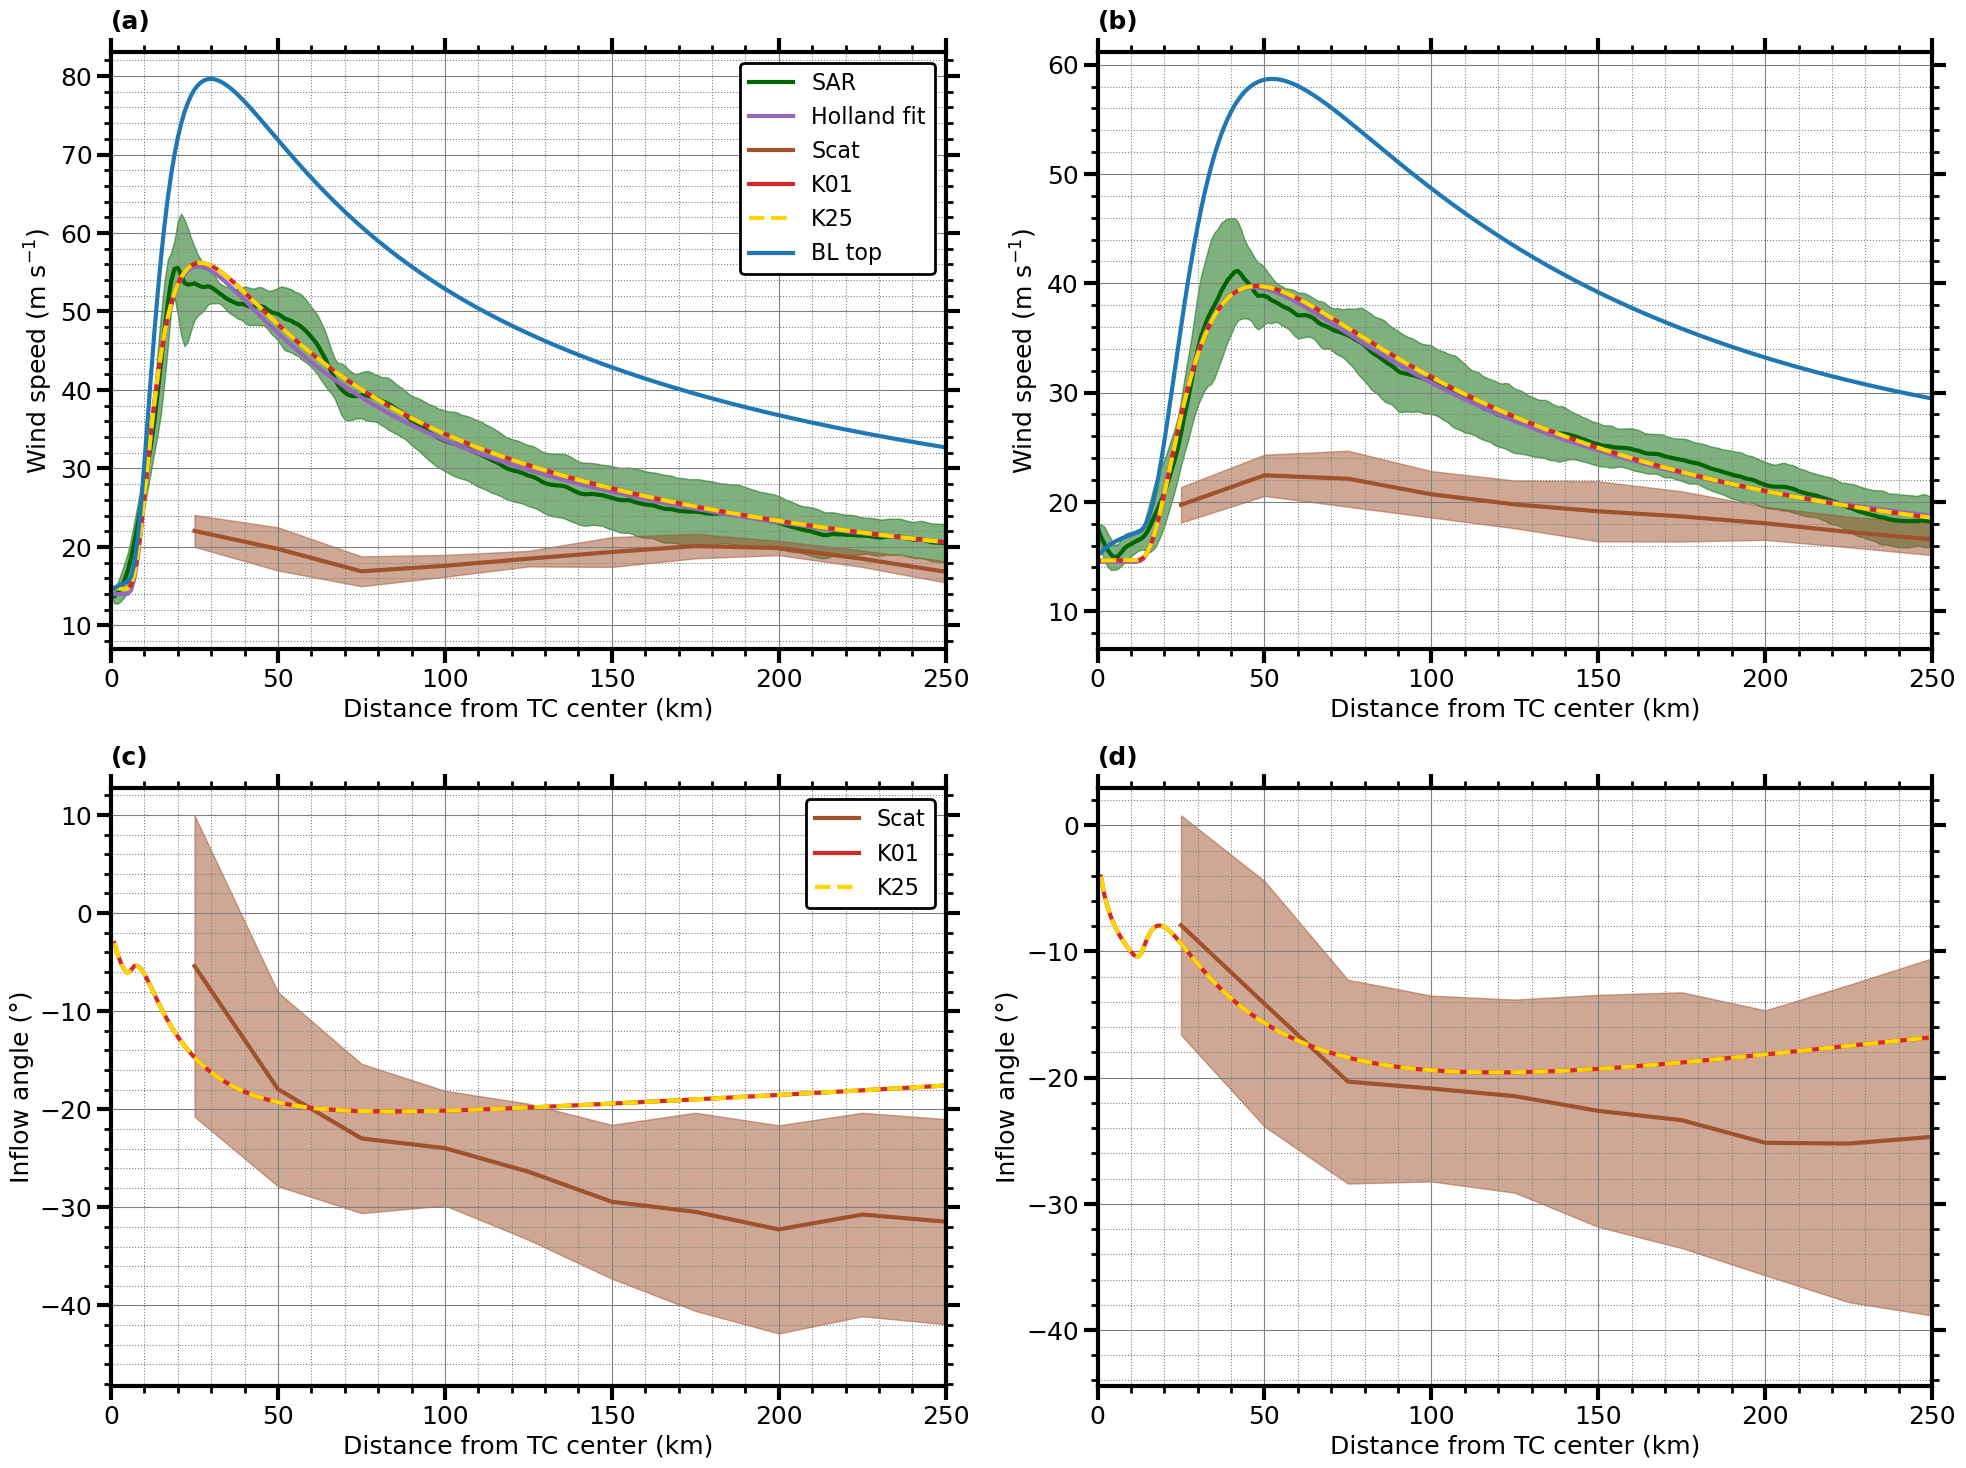

In [173]:
# Create figure with subplots
fig = plt.figure(figsize=(20, 15))
gs  = GridSpec(2, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax_lims2D  = 150

###################
###   WINDS A   ###
###################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# SAR winds
ax1.plot(wsma.rad / 1000, wsma, linewidth=3, c=c_sar, label='SAR')
ax1.fill_between(wsma.rad / 1000, wsma - wssa, wsma + wssa, alpha=0.5, color=c_sar)
# Holland
ax1.plot(rs / 1000, VholA, c=c_hol, linewidth=3, label='Holland fit')
# SCT winds
ax1.plot(wsmSctA.rad / 1000, wsmSctA, linewidth=3, c=c_sct, label='Scat')
ax1.fill_between(wsmSctA.rad / 1000, wsmSctA - wssSctA, wsmSctA + wssSctA, alpha=0.5, color=c_sct)
# KXX winds
ax1.plot(wsmK01A.rad / 1000, wsmK01A, linewidth=3, c=c_k01, label='K01')
ax1.plot(wsmK01A.rad / 1000, wsmK01A, linewidth=3, c=c_k25, linestyle='dashed', label='K25')
# BL winds
ax1.plot(rs / 1000, VholA / wrfA[0, 0, :], c=c_tbl, linewidth=3, label='BL top')

ax1.set_xlim(0, ax_lims2D)
# ax1.set_ylim(-ax_lims2D, ax_lims2D)
ax1.set_xlabel('Distance from TC center (km)')
ax1.set_ylabel(r'Wind speed (m s$^{-1}$)')

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

# ax1.legend(frameon=False, loc='upper right')
# Create the legend with specific styling
leg = ax1.legend(
    loc='upper right',
    frameon=True,          # Turn the frame back ON
    fancybox=True,         # True = Rounded corners, False = Square corners
    framealpha=1.0,        # 1.0 = Opaque background (hides gridlines behind legend)
    edgecolor='black',     # Border color
    fontsize=16            # Ensure text is readable
)
leg.get_frame().set_linewidth(2.0)

###################
###   WINDS B   ###
###################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# SAR winds
ax2.plot(wsmb.rad / 1000, wsmb, linewidth=3, c=c_sar)
ax2.fill_between(wsmb.rad / 1000, wsmb - wssb, wsmb + wssb, alpha=0.5, color=c_sar)
# Holland
ax2.plot(rs / 1000, VholB, c=c_hol, linewidth=3)
# SCT winds
ax2.plot(wsmSctB.rad / 1000, wsmSctB, linewidth=3, c=c_sct)
ax2.fill_between(wsmSctB.rad / 1000, wsmSctB - wssSctB, wsmSctB + wssSctB, alpha=0.5, color=c_sct)
# KXX winds
ax2.plot(wsmK01B.rad / 1000, wsmK01B, linewidth=3, c=c_k01)
ax2.plot(wsmK01B.rad / 1000, wsmK01B, linewidth=3, c=c_k25, linestyle='dashed')
# BL winds
ax2.plot(rs / 1000, VholB / wrfB[0, 0, :], c=c_tbl, linewidth=3)

ax2.set_xlim(0, ax_lims2D)
# ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.set_xlabel('Distance from TC center (km)')
ax2.set_ylabel(r'Wind speed (m s$^{-1}$)')

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)

#####################
###   INF ANG A   ###
#####################
ax3.text(0.0, 1.03, '(c)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# SCT winds
ax3.plot(iamSctA.rad / 1000, iamSctA, linewidth=3, c=c_sct, label='Scat')
ax3.fill_between(iamSctA.rad / 1000, iamSctA - iasSctA, iamSctA + iasSctA, alpha=0.5, color=c_sct)
# KXX winds
ax3.plot(iamK01A.rad / 1000, iamK01A, linewidth=3, c=c_k01, label='K01')
ax3.plot(iamK01A.rad / 1000, iamK01A, linewidth=3, c=c_k25, linestyle='dashed', label='K25')

ax3.set_xlim(0, ax_lims2D)
# ax3.set_ylim(-ax_lims2D, ax_lims2D)
ax3.set_xlabel('Distance from TC center (km)')
ax3.set_ylabel(r'Inflow angle (°)')

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)

# ax3.legend(frameon=False, loc='upper right')
# Create the legend with specific styling
leg = ax3.legend(
    loc='upper right',
    frameon=True,          # Turn the frame back ON
    fancybox=True,         # True = Rounded corners, False = Square corners
    framealpha=1.0,        # 1.0 = Opaque background (hides gridlines behind legend)
    edgecolor='black',     # Border color
    fontsize=16            # Ensure text is readable
)
leg.get_frame().set_linewidth(2.0)

#####################
###   INF ANG B   ###
#####################
ax4.text(0.0, 1.03, '(d)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# SCT winds
ax4.plot(iamSctB.rad / 1000, iamSctB, linewidth=3, c=c_sct)
ax4.fill_between(iamSctB.rad / 1000, iamSctB - iasSctB, iamSctB + iasSctB, alpha=0.5, color=c_sct)
# KXX winds
ax4.plot(iamK01B.rad / 1000, iamK01B, linewidth=3, c=c_k01)
ax4.plot(iamK01B.rad / 1000, iamK01B, linewidth=3, c=c_k25, linestyle='dashed')

ax4.set_xlim(0, ax_lims2D)
# ax4.set_ylim(-ax_lims2D, ax_lims2D)
ax4.set_xlabel('Distance from TC center (km)')
ax4.set_ylabel(r'Inflow angle (°)')

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Final adjustments
plt.tight_layout()

# # Save
# plt.savefig(PTHS['sav_dir'] + 'Wind_profiles.png', bbox_inches='tight')